## Lambda = 0.7

In [1]:
# 1) Disable automatic output-scrolling/truncation
from IPython.display import display, HTML
display(HTML("""
<script>
  // prevent Jupyter from collapsing long output
  Jupyter.OutputArea.prototype._should_scroll = function(lines) { return false; }
</script>
"""))

# 2) Make sure your figures appear inline
%matplotlib inline

In [2]:
# Standard imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
import os
import pickle
from tqdm import tqdm
import random

# PyTorch GradCAM imports
from pytorch_grad_cam import GradCAM as PyTorchGradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
batch_size = 64
image_size = 32
nc = 3  # Number of channels in the training images
nz = 100  # Size of z latent vector
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
num_epochs = 10 #150
lr = 0.0002
beta1 = 0.5  # Beta1 hyperparameter for Adam optimizer
lambda_gradcam = 0.7  # Weight for GradCAM loss 0.5, 0.7, 1.0 are the three options

# Create output directory for results
os.makedirs('results', exist_ok=True)
print('done')

Using device: cuda
done


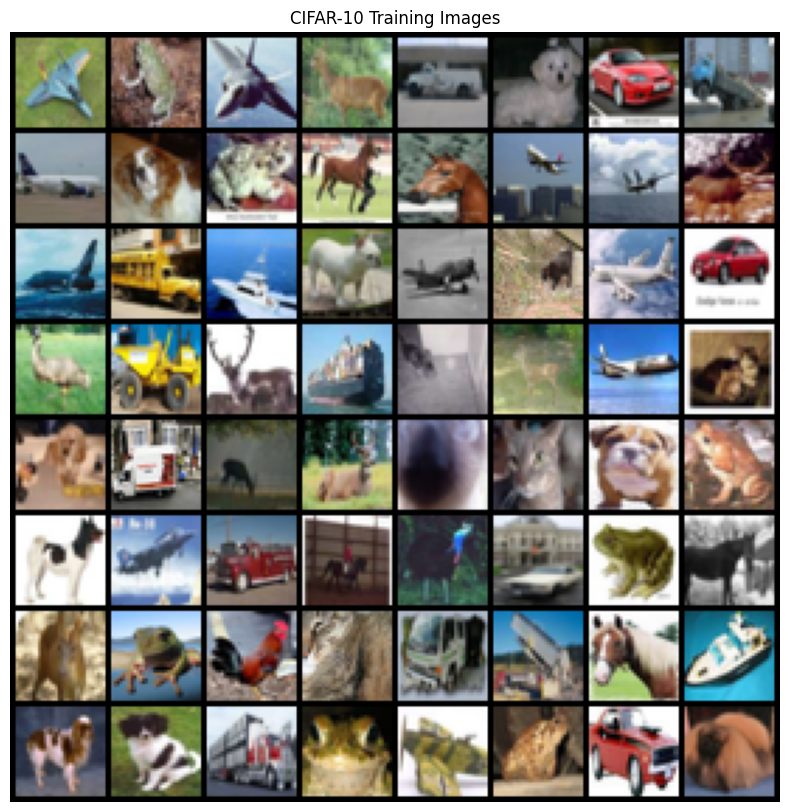

In [3]:
# Data loading
from torch.utils.data import random_split, DataLoader

val_pct = 0.2


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                              download=True, transform=transform)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                             download=True, transform=transform)

n_val = int(len(cifar_trainset) * val_pct)
n_train = len(cifar_trainset) - n_val

train_subset, val_subset = random_split(cifar_trainset, [n_train, n_val])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

# Helper function to display images
def show_images(images, title=None):
    """Display a batch of images"""
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.imshow(np.transpose(make_grid(images, padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

# Display some training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
show_images(images[:64], title='CIFAR-10 Training Images')

In [4]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_mobilenetv2_x1_0", pretrained=True)
print("Loaded Pretrained MobileNetV2 on CIFAR-10!")

model = model.to(device)
model.eval()

# Function to find the last conv layer in MobileNetV2
def get_last_conv_layer(model):
    # Get all modules in the model
    modules = list(model.named_modules())
    
    # Loop through modules in reverse order to find the last conv layer
    for name, module in reversed(modules):
        if isinstance(module, torch.nn.Conv2d):
            print(f"Found last conv layer: {name}")
            return module
    
    # If not found, return the last layer of features
    print("Using last feature layer as fallback")
    return model.features[-1]

# Get the last convolutional layer
last_conv_layer = get_last_conv_layer(model)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Loaded Pretrained MobileNetV2 on CIFAR-10!
Found last conv layer: features.18.0


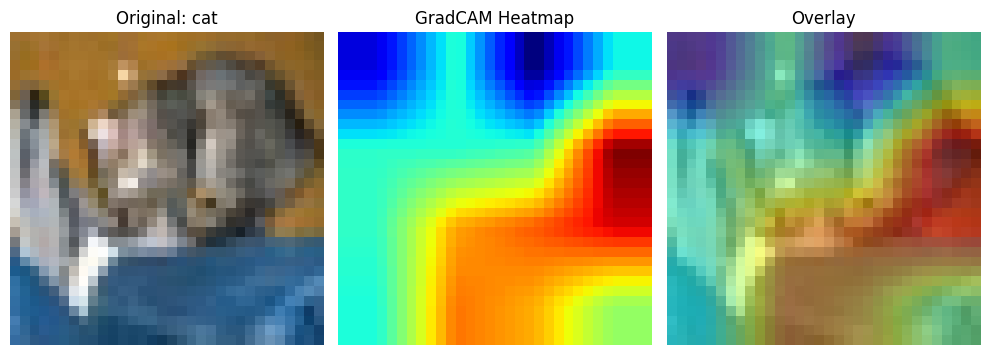

GradCAM test complete!


In [5]:
# Initialize GradCAM with the pre-trained model
# Note: Removed the use_cuda parameter that was causing the error
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

cam = GradCAM(
    model=model,  # Your pre-trained MobileNetV2
    target_layers=[last_conv_layer]  # The last conv layer you identified
)

# Function to generate Grad-CAM heatmaps
def generate_gradcam_heatmap(image, class_idx):
    try:
        # Detach from computation graph before converting to NumPy
        image_np = image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        # Normalize and preprocess for Grad-CAM
        input_tensor = preprocess_image(image_np, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        
        # Wrap class_idx properly
        target = [ClassifierOutputTarget(class_idx)]
        
        grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0]
        return grayscale_cam
    except Exception as e:
        print(f"Error in generate_gradcam_heatmap: {e}")
        # Return a fallback heatmap (uniform distribution)
        return np.ones((32, 32), dtype=np.float32) * 0.5
        
# Function to visualize GradCAM heatmaps
def visualize_gradcam(model, images, labels=None, classes=None):
    """Visualize GradCAM heatmaps for a batch of images"""
    model.eval()
    plt.figure(figsize=(15, 4*len(images)))
    
    for i, image in enumerate(images):
        # Process image
        img_tensor = image.unsqueeze(0).to(device)
        
        # Get prediction if labels not provided
        if labels is None:
            with torch.no_grad():
                output = model(img_tensor)
                _, pred = torch.max(output, 1)
                pred = pred.item()
        else:
            # Just use the label directly - no need to call .item() as we already did that in main()
            pred = labels[i]
        
        # Generate heatmap
        heatmap = generate_gradcam_heatmap(img_tensor, pred)
        
        # Display original image
        plt.subplot(len(images), 3, i*3+1)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
        if classes:
            plt.title(f'Class: {classes[pred]}')
        else:
            plt.title(f'Class: {pred}')
        plt.axis('off')
        
        # Display heatmap
        plt.subplot(len(images), 3, i*3+2)
        plt.imshow(heatmap, cmap='jet')
        plt.title('GradCAM Heatmap')
        plt.axis('off')
        
        # Display overlay
        plt.subplot(len(images), 3, i*3+3)
        img_np = image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
        plt.imshow(img_np)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
# Test the GradCAM function with a sample image
def test_gradcam():
    # Get a sample image
    test_batch = next(iter(testloader))
    test_image = test_batch[0][0].unsqueeze(0).to(device)
    test_label = test_batch[1][0].item()
    
    # Generate heatmap
    heatmap = generate_gradcam_heatmap(test_image, test_label)
    
    # Display the results
    plt.figure(figsize=(10, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    img_np = test_image.squeeze().cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
    plt.imshow(img_np)
    plt.title(f'Original: {classes[test_label]}')
    plt.axis('off')
    
    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('GradCAM Heatmap')
    plt.axis('off')
    
    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(img_np)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title('Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("GradCAM test complete!")
    return heatmap

# Function to generate class-specific GradCAM heatmaps
def generate_class_heatmaps(model, dataloader, num_samples=50):
    """Generate and store GradCAM heatmaps for each class"""
    class_heatmaps = {i: [] for i in range(10)}  # 10 classes in CIFAR-10
    
    model.eval()
    count = {i: 0 for i in range(10)}
    
    for data in tqdm(dataloader, desc="Generating class heatmaps"):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        for i in range(images.size(0)):
            label = labels[i].item()
            
            if count[label] < num_samples:
                image = images[i:i+1]
                
                # Get prediction
                with torch.no_grad():
                    output = model(image)
                    _, predicted = torch.max(output, 1)
                
                # Only use correctly classified images
                if predicted.item() == label:
                    try:
                        # Generate heatmap
                        heatmap = generate_gradcam_heatmap(image, label)
                        
                        # Convert to tensor
                        heatmap_tensor = torch.from_numpy(heatmap).float().unsqueeze(0).unsqueeze(0)
                        
                        class_heatmaps[label].append(heatmap_tensor)
                        count[label] += 1
                    except Exception as e:
                        print(f"Error generating heatmap: {e}")
                        continue
        
        # Check if we have enough samples for each class
        if all(count[i] >= num_samples for i in range(10)):
            break
    
    print(f"Generated heatmaps: {[len(class_heatmaps[i]) for i in range(10)]}")
    return class_heatmaps
    
# Uncomment to test the GradCAM function
test_result = test_gradcam()

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input.view(-1, nz, 1, 1))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            # No Sigmoid here, will use BCEWithLogitsLoss
        )

    def forward(self, input):
        return self.main(input)

# Initialize networks
def initialize_networks():
    """Initialize Generator and Discriminator networks"""
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    
    # Initialize weights
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    return netG, netD

In [7]:
# Custom function to compute SSIM loss
def ssim_loss(img1, img2):
    """Compute SSIM loss between two tensors (heatmaps)"""
    # Convert to numpy arrays for SSIM calculation
    img1_np = img1.detach().cpu().numpy().squeeze()
    img2_np = img2.detach().cpu().numpy().squeeze()
    
    # Calculate SSIM
    ssim_value = ssim(img1_np, img2_np, data_range=1.0)
    
    # Return 1 - SSIM as the loss (higher SSIM = lower loss)
    return 1.0 - ssim_value

# Custom function to compute Pearson correlation loss
def pearson_loss(img1, img2):
    """Compute Pearson correlation loss between two tensors (heatmaps)"""
    # Flatten tensors
    img1_flat = img1.view(-1).detach().cpu().numpy()
    img2_flat = img2.view(-1).detach().cpu().numpy()
    
    # Calculate Pearson correlation
    pearson_corr, _ = pearsonr(img1_flat, img2_flat)
    
    # Handle NaN values
    if np.isnan(pearson_corr):
        pearson_corr = 0.0
    
    # Return 1 - correlation as the loss (higher correlation = lower loss)
    return 1.0 - pearson_corr

# Function to compute GradCAM region emphasis loss
def gradcam_region_emphasis_loss(real_heatmap, fake_heatmap):
    """Compute combined GradCAM region emphasis loss"""
    # Compute SSIM and Pearson losses
    ssim_l = ssim_loss(real_heatmap, fake_heatmap)
    pearson_l = pearson_loss(real_heatmap, fake_heatmap)
    
    # Return average of both losses
    return 0.5 * (ssim_l + pearson_l)

In [8]:
# GAN Training with GradCAM (5-sample heatmap comparison)
def train_gan_with_gradcam(pretrained_model, class_heatmaps, netG, netD, num_epochs=50):
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    fixed_noise = torch.randn(16, nz, 1, 1, device=device)

    g_losses, d_losses, gc_losses = [], [], []
    val_g_losses, val_d_losses, val_gc_losses = [], [], []

    for epoch in range(num_epochs):
        netG.train()
        netD.train()
        for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            real_images, _ = data
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # ---- Train Discriminator ----
            netD.zero_grad()
            label = torch.full((batch_size,), 1., device=device)
            output = netD(real_images).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()

            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            label.fill_(0.)
            output = netD(fake_images.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optimizerD.step()

            # ---- Train Generator ----
            netG.zero_grad()
            label.fill_(1.)
            output = netD(fake_images).view(-1)
            errG_gan = criterion(output, label)

            pretrained_model.eval()
            with torch.no_grad():
                logits = pretrained_model(fake_images)
                preds = logits.argmax(dim=1)

            gradcam_loss_value = 0.
            valid_count = 0
            for j in range(batch_size):
                cls = preds[j].item()
                if class_heatmaps[cls] and len(class_heatmaps[cls]) >= 5:
                    try:
                        hm = generate_gradcam_heatmap(fake_images[j:j+1], cls)
                        fake_hm = torch.from_numpy(hm).float().unsqueeze(0).unsqueeze(0).to(device)

                        real_hms = random.sample(class_heatmaps[cls], k=5)
                        losses = [gradcam_region_emphasis_loss(r.to(device), fake_hm) for r in real_hms]
                        gradcam_loss_value += sum(losses) / len(losses)
                        valid_count += 1
                    except Exception as e:
                        print(f"skipping heatmap: {e}")

            if valid_count > 0:
                gradcam_loss_value /= valid_count
                gc_losses.append(gradcam_loss_value.item())
            else:
                gradcam_loss_value = 0.
                print("gradcam_loss_value is zero")

            errG = errG_gan + lambda_gradcam * gradcam_loss_value
            errG.backward()
            optimizerG.step()

            g_losses.append(errG.item())
            d_losses.append(errD.item())

            if i % 50 == 0:
                print(f"[{epoch+1}/{num_epochs}][{i}/{len(trainloader)}] "
                      f"Loss_D: {errD.item():.4f}, Loss_G: {errG.item():.4f}, GC: {gradcam_loss_value:.4f}")
                
        print(f"==> Epoch {epoch+1} TRAIN Losses | D: {errD.item():.4f} | G: {errG.item():.4f} | GC: {gradcam_loss_value:.4f}")

        # ---- Validation pass at end of epoch ----
        # === validation pass ===
        netG.eval(); netD.eval()
        run_d, run_g = 0., 0.
        n_batches = 0

        # 1) GAN val losses (no grad)
        with torch.no_grad():
            for real_images, _ in valloader:
                real_images = real_images.to(device)
                bs = real_images.size(0)

                # D‐val
                lbl = torch.full((bs,), 1., device=device)
                r_out = netD(real_images).view(-1)
                eDr = criterion(r_out, lbl)

                noise = torch.randn(bs, nz, 1, 1, device=device)
                f_imgs = netG(noise)
                lbl.fill_(0.)
                f_out = netD(f_imgs).view(-1)
                eDf = criterion(f_out, lbl)

                run_d += (eDr + eDf).item()

                # G‐val (GAN component)
                lbl.fill_(1.)
                eGv = criterion(netD(f_imgs).view(-1), lbl)
                run_g += eGv.item()

                n_batches += 1

        val_d_losses.append(run_d / n_batches)
        val_g_losses.append(run_g / n_batches)

        # 2) GradCAM val loss (with grad)
        run_gc = 0.
        valid_batches = 0
        for _, _ in valloader:
            # regenerate fakes WITH grad
            noise = torch.randn(bs, nz, 1, 1, device=device)
            fake_images = netG(noise)
            fake_images.requires_grad_(True)

            # forward through pretrained with grad enabled
            pretrained_model.eval()
            with torch.enable_grad():
                logits = pretrained_model(fake_images)
                preds = logits.argmax(dim=1)

            # compute per-sample GradCAM
            batch_gc = 0.
            cnt = 0
            for j in range(bs):
                cls = preds[j].item()
                if class_heatmaps[cls] and len(class_heatmaps[cls]) >= 5:
                    try:
                        hm = generate_gradcam_heatmap(fake_images[j:j+1], cls)
                        fake_hm = (torch.from_numpy(hm)
                                        .float()
                                        .unsqueeze(0)
                                        .unsqueeze(0)
                                        .to(device))
                        real_hms = random.sample(class_heatmaps[cls], k=5)
                        losses = [gradcam_region_emphasis_loss(r.to(device), fake_hm)
                                  for r in real_hms]
                        batch_gc += sum(losses) / len(losses)
                        cnt += 1
                    except Exception as e:
                        print(f"val GC skip: {e}")

            if cnt > 0:
                run_gc += batch_gc.item() / cnt
                valid_batches += 1

        # average and record
        if valid_batches > 0:
            val_gc_losses.append(run_gc / valid_batches)
        else:
            val_gc_losses.append(0.)

        print(f"==> Epoch {epoch+1} VAL | D: {val_d_losses[-1]:.4f} | "
              f"G: {val_g_losses[-1]:.4f} | GC: {val_gc_losses[-1]:.4f}")

        # ---- Save samples every 5 epochs ----
        if (epoch+1) % 5 == 0 or epoch == num_epochs-1:
            with torch.no_grad():
                samples = netG(fixed_noise).cpu()
            save_image(make_grid(samples, padding=2, normalize=True),
                       f'results/fake_samples_0_7_epoch_{epoch+1}.png')
            print(f"Saved samples at epoch {epoch+1}")

    # ---- final save ----
    torch.save(netG.state_dict(), 'results/generator0_7.pth')
    torch.save(netD.state_dict(), 'results/discriminator0_7.pth')

    # ---- Plotting ----
    plt.figure(figsize=(18, 5))

    # 1) train G vs D
    plt.subplot(1, 3, 1)
    plt.plot(g_losses, label='Train G')
    plt.plot(d_losses, label='Train D')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training GAN Losses')

    # 2) GradCAM loss
    plt.subplot(1, 3, 2)
    if gc_losses:
        plt.plot(gc_losses, label='GradCAM Loss')
        plt.xlabel('Iteration (valid GC)')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('GradCAM')

    # 3) validation G vs D
    plt.subplot(1, 3, 3)
    plt.plot(val_g_losses, label='Val G')
    plt.plot(val_d_losses, label='Val D')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Validation GAN Losses')

    plt.tight_layout()
    plt.savefig('results/gan_loss_curves0_7.png')
    plt.show()

    return netG, netD, g_losses, d_losses, gc_losses, val_g_losses, val_d_losses

In [9]:
# Evaluation and Visualization Functions
def compare_real_fake_heatmaps(pretrained_model, netG, testloader, classes, n_samples=8):
    """Compare GradCAM heatmaps between real and generated images using pre-trained model"""
    pretrained_model.eval()
    netG.eval()
    
    # Get a batch of real images
    real_batch = next(iter(testloader))
    real_images = real_batch[0][:n_samples].to(device)
    real_labels = real_batch[1][:n_samples].to(device)
    
    # Generate fake images
    noise = torch.randn(n_samples, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_images = netG(noise)
    
    # Generate and compare heatmaps
    plt.figure(figsize=(16, 3*n_samples))
    
    for i in range(n_samples):
        # Real image
        real_image = real_images[i:i+1]
        real_label = real_labels[i].item()
        
        # Get prediction for real image
        with torch.no_grad():
            real_output = pretrained_model(real_image)
            _, real_pred = torch.max(real_output, 1)
            real_pred = real_pred.item()
        
        # Generate heatmap for real image
        real_heatmap = generate_gradcam_heatmap(real_image, real_pred)
        
        # Fake image
        fake_image = fake_images[i:i+1]
        
        # Get prediction for fake image
        with torch.no_grad():
            fake_output = pretrained_model(fake_image)
            _, fake_pred = torch.max(fake_output, 1)
            fake_pred = fake_pred.item()
        
        # Generate heatmap for fake image
        fake_heatmap = generate_gradcam_heatmap(fake_image, fake_pred)
        
        # Plot real image and its heatmap
        plt.subplot(n_samples, 4, i*4+1)
        plt.imshow(real_image.cpu().squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(f'Real: {classes[real_label]}\nPred: {classes[real_pred]}')
        plt.axis('off')
        
        plt.subplot(n_samples, 4, i*4+2)
        plt.imshow(real_heatmap, cmap='jet')
        plt.title('Real GradCAM')
        plt.axis('off')
        
        # Plot fake image and its heatmap
        plt.subplot(n_samples, 4, i*4+3)
        plt.imshow(fake_image.cpu().squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5)
        plt.title(f'Fake: {classes[fake_pred]}')
        plt.axis('off')
        
        plt.subplot(n_samples, 4, i*4+4)
        plt.imshow(fake_heatmap, cmap='jet')
        plt.title('Fake GradCAM')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/gradcam_comparison0_7.png')
    plt.show()
    
    return real_images, fake_images

# Function to calculate metrics between real and fake heatmaps
def calculate_heatmap_metrics(pretrained_model, real_images, fake_images, n_samples=100):
    """Calculate metrics between real and fake GradCAM heatmaps"""
    pretrained_model.eval()
    
    ssim_values = []
    pearson_values = []
    
    for i in range(min(len(real_images), len(fake_images), n_samples)):
        try:
            # Real image
            real_image = real_images[i:i+1].to(device)
            
            # Get prediction for real image
            with torch.no_grad():
                real_output = pretrained_model(real_image)
                _, real_pred = torch.max(real_output, 1)
                real_pred = real_pred.item()
            
            # Generate heatmap for real image
            real_heatmap_np = generate_gradcam_heatmap(real_image, real_pred)
            real_heatmap = torch.from_numpy(real_heatmap_np).float().unsqueeze(0).unsqueeze(0)
            
            # Fake image
            fake_image = fake_images[i:i+1].to(device)
            
            # Generate heatmap for fake image - use same class as real for comparison
            fake_heatmap_np = generate_gradcam_heatmap(fake_image, real_pred)
            fake_heatmap = torch.from_numpy(fake_heatmap_np).float().unsqueeze(0).unsqueeze(0)
            
            # Calculate metrics
            ssim_val = 1.0 - ssim_loss(real_heatmap, fake_heatmap)  # Convert loss to similarity
            pearson_val = 1.0 - pearson_loss(real_heatmap, fake_heatmap)  # Convert loss to similarity
            
            ssim_values.append(ssim_val)
            pearson_values.append(pearson_val)
        except Exception as e:
            print(f"Error calculating metrics for sample {i}: {e}")
            continue
    
    # Calculate statistics
    if ssim_values and pearson_values:
        ssim_mean = np.mean(ssim_values)
        ssim_std = np.std(ssim_values)
        pearson_mean = np.mean(pearson_values)
        pearson_std = np.std(pearson_values)
        
        print(f"SSIM: Mean = {ssim_mean:.4f}, Std = {ssim_std:.4f}")
        print(f"Pearson Correlation: Mean = {pearson_mean:.4f}, Std = {pearson_std:.4f}")
        
        # Plot histogram of values
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(ssim_values, bins=20, alpha=0.7)
        plt.axvline(ssim_mean, color='r', linestyle='dashed', linewidth=1)
        plt.title(f'SSIM Values: Mean = {ssim_mean:.4f}')
        plt.xlabel('SSIM (higher is better)')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 2, 2)
        plt.hist(pearson_values, bins=20, alpha=0.7)
        plt.axvline(pearson_mean, color='r', linestyle='dashed', linewidth=1)
        plt.title(f'Pearson Values: Mean = {pearson_mean:.4f}')
        plt.xlabel('Pearson Correlation (higher is better)')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.savefig('results/heatmap_metrics0_7.png')
        plt.show()
        
        return {
            'ssim_mean': ssim_mean,
            'ssim_std': ssim_std,
            'pearson_mean': pearson_mean,
            'pearson_std': pearson_std,
            'ssim_values': ssim_values,
            'pearson_values': pearson_values
        }
    else:
        print("Not enough valid samples to calculate metrics")
        return None

# Function to generate samples with the trained generator
def generate_samples(netG, n_samples=100, n_display=64):
    """Generate samples using the trained generator"""
    netG.eval()
    
    # Generate images
    noise = torch.randn(n_samples, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_images = netG(noise).detach().cpu()
    
    # Display a subset of generated images
    if n_display > 0:
        plt.figure(figsize=(10, 10))
        plt.axis('off')
        plt.title(f"{n_display} Generated Images")
        plt.imshow(np.transpose(make_grid(fake_images[:n_display], 
                                        padding=2, normalize=True), (1, 2, 0)))
        plt.savefig('results/final_samples0_7.png')
        plt.show()
    
    return fake_images

In [10]:
# Main execution function
def main():

    print("Step 1: Setting up pre-trained classifier")
    # Pre-trained model and GradCAM are already set up (model & cam variables)
    
    print("Step 2: Testing GradCAM visualization")
    # Test GradCAM with a few images
    test_batch = next(iter(testloader))
    test_images, test_labels = test_batch
    
    # Convert tensor labels to Python integers before passing to visualize_gradcam
    test_labels_list = [label.item() for label in test_labels[:5]]
    visualize_gradcam(model, test_images[:5], test_labels_list, classes)
    
    print("Step 3: Generating Class-Specific GradCAM Heatmaps")
    # Try loading existing heatmaps first
    try:
        with open('results/class_heatmaps0_7.pkl', 'rb') as f:
            class_heatmaps = pickle.load(f)
        print("Loaded existing heatmaps from disk")
    except:
        print("Generating new heatmaps")
        class_heatmaps = generate_class_heatmaps(model, trainloader, num_samples=50)
        # Save heatmaps to avoid regenerating them
        os.makedirs('results', exist_ok=True)
        with open('results/class_heatmaps0_7.pkl', 'wb') as f:
            pickle.dump(class_heatmaps, f)
        print("Saved heatmaps to disk")
    
    print("Step 4: Initializing GAN Networks")
    netG, netD = initialize_networks()
    
    print("Step 5: Training GAN with GradCAM Guidance")
    # You can adjust the number of epochs based on your computational resources
    netG, netD, g_losses, d_losses, gc_losses, val_g_losses, val_d_losses = train_gan_with_gradcam(model, class_heatmaps, netG, netD, num_epochs=num_epochs)
    
    print("Step 6: Evaluating GAN with GradCAM")
    real_images, fake_images = compare_real_fake_heatmaps(model, netG, testloader, classes)
    metrics = calculate_heatmap_metrics(model, real_images, fake_images)
    
    print("Step 7: Generating Final Samples")
    generated_samples = generate_samples(netG, n_samples=100)
    
    print("All steps completed!")

Step 1: Setting up pre-trained classifier
Step 2: Testing GradCAM visualization


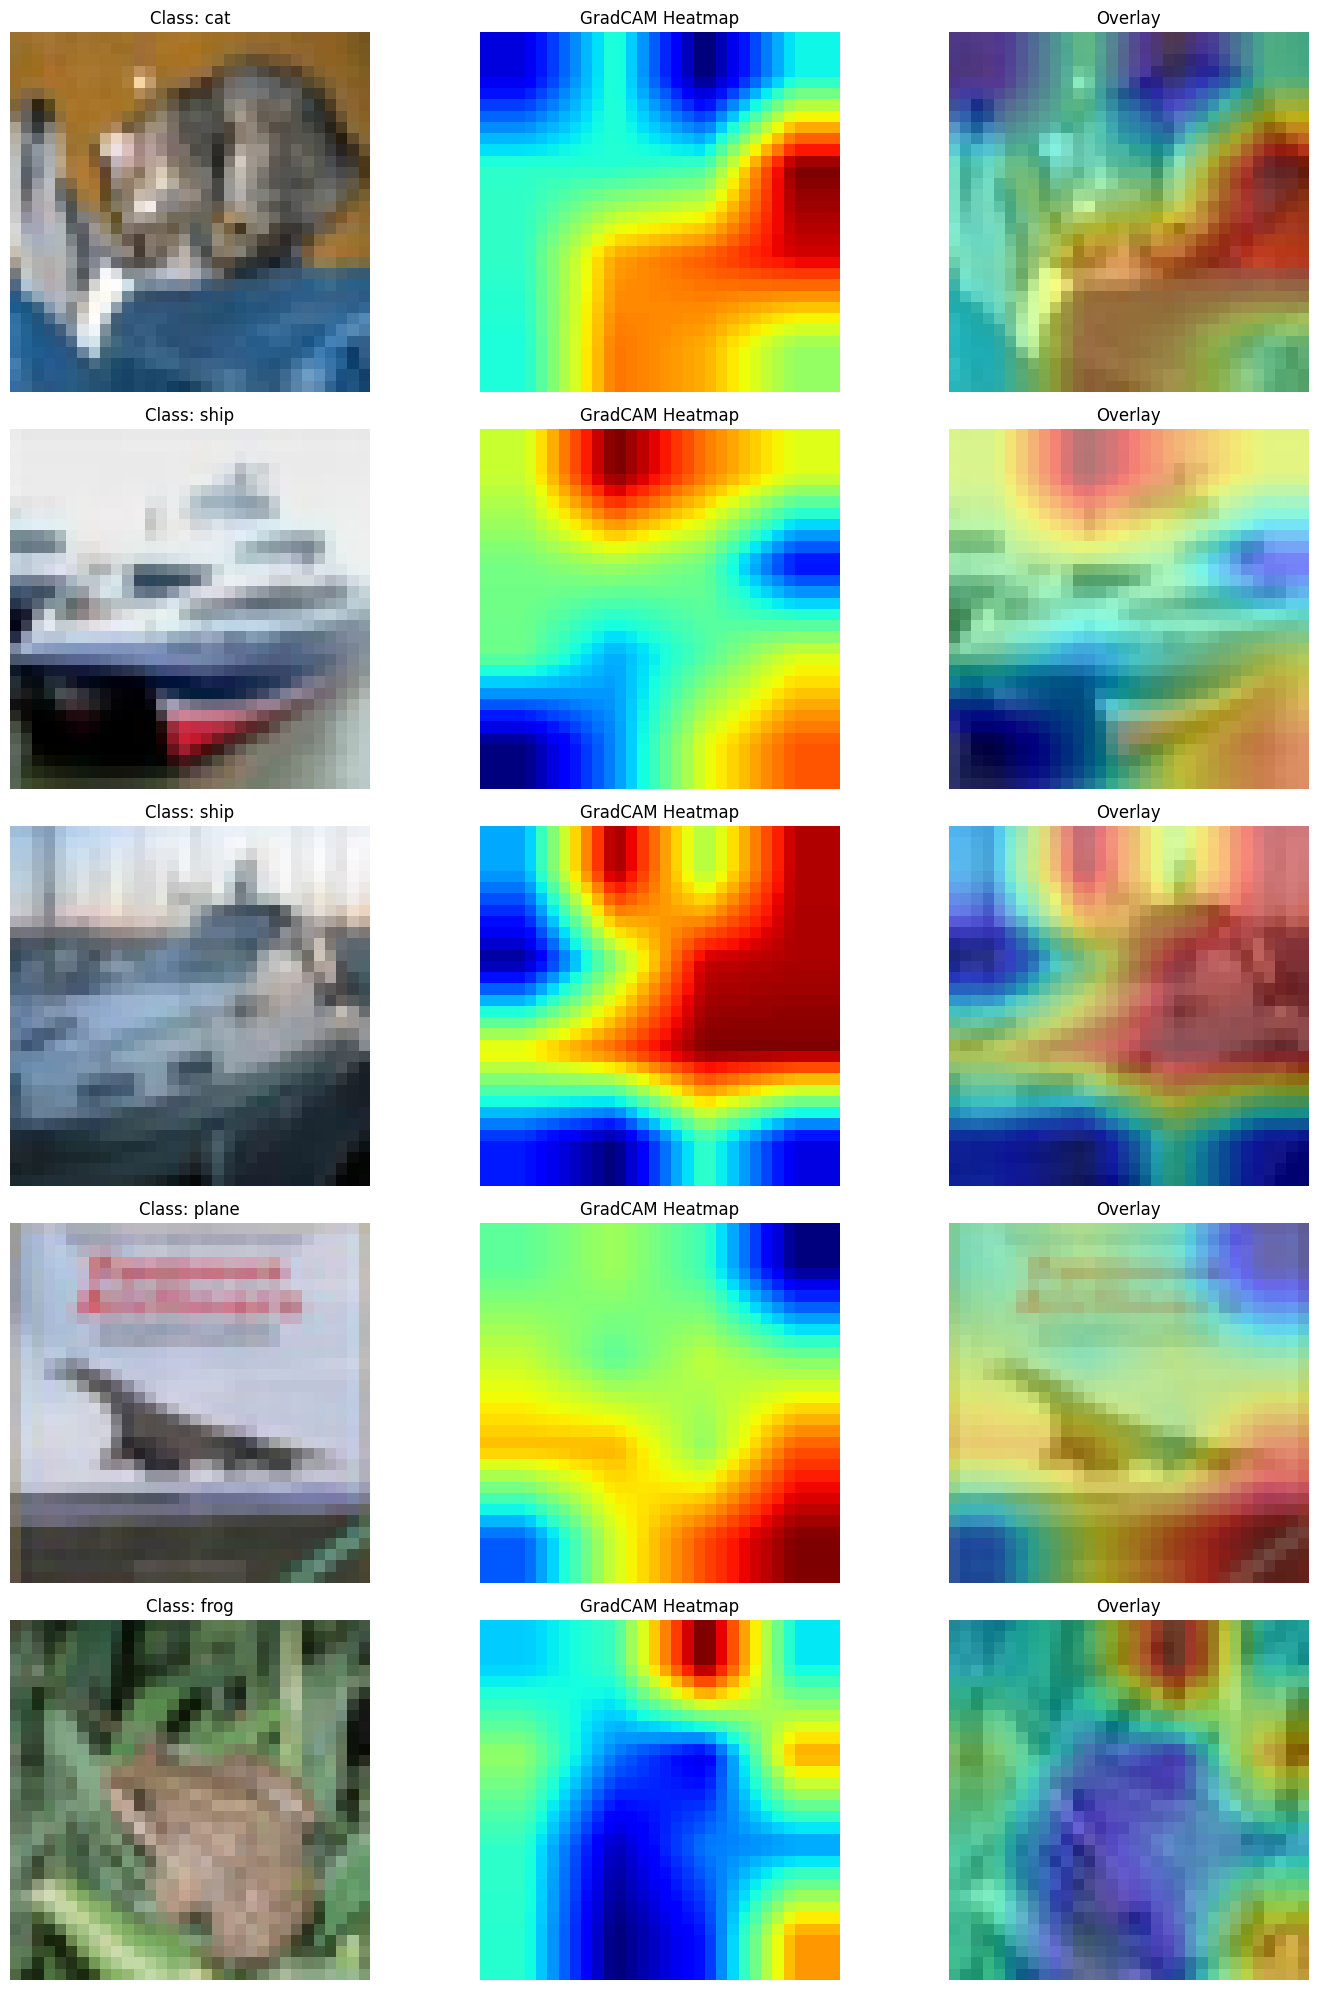

Step 3: Generating Class-Specific GradCAM Heatmaps
Generating new heatmaps


Generating class heatmaps:   2%|▏         | 11/625 [00:17<16:03,  1.57s/it]


Generated heatmaps: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Saved heatmaps to disk
Step 4: Initializing GAN Networks
Step 5: Training GAN with GradCAM Guidance


Epoch 1/10:   0%|          | 1/625 [00:02<28:29,  2.74s/it]

[1/10][0/625] Loss_D: 1.5946, Loss_G: 2.9338, GC: 0.9980


Epoch 1/10:   8%|▊         | 51/625 [02:07<23:19,  2.44s/it]

[1/10][50/625] Loss_D: 0.4780, Loss_G: 6.5251, GC: 0.9484


Epoch 1/10:  16%|█▌        | 101/625 [04:07<21:32,  2.47s/it]

[1/10][100/625] Loss_D: 0.1904, Loss_G: 6.3789, GC: 0.9981


Epoch 1/10:  24%|██▍       | 151/625 [06:10<19:51,  2.51s/it]

[1/10][150/625] Loss_D: 0.4392, Loss_G: 4.1662, GC: 0.9763


Epoch 1/10:  28%|██▊       | 178/625 [07:18<18:40,  2.51s/it]/tmp/ipykernel_11997/346551886.py:22: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(img1_flat, img2_flat)
Epoch 1/10:  32%|███▏      | 201/625 [08:17<17:53,  2.53s/it]

[1/10][200/625] Loss_D: 0.5878, Loss_G: 3.8447, GC: 1.0029


Epoch 1/10:  40%|████      | 251/625 [10:23<14:59,  2.41s/it]

[1/10][250/625] Loss_D: 0.2629, Loss_G: 5.0926, GC: 0.9806


Epoch 1/10:  48%|████▊     | 301/625 [12:15<09:58,  1.85s/it]

[1/10][300/625] Loss_D: 0.3414, Loss_G: 5.4385, GC: 1.0012


Epoch 1/10:  56%|█████▌    | 351/625 [14:19<11:26,  2.51s/it]

[1/10][350/625] Loss_D: 0.7571, Loss_G: 4.1169, GC: 0.9333


Epoch 1/10:  64%|██████▍   | 401/625 [16:22<09:14,  2.48s/it]

[1/10][400/625] Loss_D: 0.7490, Loss_G: 3.2284, GC: 0.9434


Epoch 1/10:  72%|███████▏  | 451/625 [18:27<07:16,  2.51s/it]

[1/10][450/625] Loss_D: 0.4367, Loss_G: 3.8032, GC: 0.8618


Epoch 1/10:  80%|████████  | 501/625 [20:28<05:09,  2.50s/it]

[1/10][500/625] Loss_D: 0.6576, Loss_G: 2.9952, GC: 0.9157


Epoch 1/10:  88%|████████▊ | 551/625 [22:27<02:35,  2.10s/it]

[1/10][550/625] Loss_D: 0.6784, Loss_G: 4.7575, GC: 0.9301


Epoch 1/10:  96%|█████████▌| 601/625 [24:27<01:00,  2.50s/it]

[1/10][600/625] Loss_D: 0.5464, Loss_G: 3.8826, GC: 0.9241


Epoch 1/10: 100%|██████████| 625/625 [25:25<00:00,  2.44s/it]

==> Epoch 1 TRAIN Losses | D: 0.4322 | G: 3.7177 | GC: 0.9274


==> Epoch 1 VAL | D: 0.7739 | G: 1.6416 | GC: 0.9316


Epoch 2/10:   0%|          | 1/625 [00:02<23:38,  2.27s/it]

[2/10][0/625] Loss_D: 0.4709, Loss_G: 3.4701, GC: 0.9398


Epoch 2/10:   8%|▊         | 51/625 [01:47<24:01,  2.51s/it]

[2/10][50/625] Loss_D: 0.5146, Loss_G: 4.0812, GC: 0.9544


Epoch 2/10:  16%|█▌        | 101/625 [03:50<22:10,  2.54s/it]

[2/10][100/625] Loss_D: 0.9951, Loss_G: 4.5297, GC: 0.9499


Epoch 2/10:  24%|██▍       | 151/625 [05:52<18:16,  2.31s/it]

[2/10][150/625] Loss_D: 0.3275, Loss_G: 4.3949, GC: 0.9765


Epoch 2/10:  32%|███▏      | 201/625 [07:48<17:15,  2.44s/it]

[2/10][200/625] Loss_D: 0.3280, Loss_G: 4.0838, GC: 0.9110


Epoch 2/10:  40%|████      | 251/625 [09:55<15:55,  2.55s/it]

[2/10][250/625] Loss_D: 0.5190, Loss_G: 3.7369, GC: 0.9540


Epoch 2/10:  48%|████▊     | 301/625 [11:52<11:58,  2.22s/it]

[2/10][300/625] Loss_D: 0.4984, Loss_G: 3.3594, GC: 0.9262


Epoch 2/10:  56%|█████▌    | 351/625 [13:50<11:04,  2.42s/it]

[2/10][350/625] Loss_D: 0.6938, Loss_G: 3.3945, GC: 0.8817


Epoch 2/10:  64%|██████▍   | 401/625 [15:49<08:52,  2.38s/it]

[2/10][400/625] Loss_D: 0.7122, Loss_G: 3.6592, GC: 0.9228


Epoch 2/10:  72%|███████▏  | 451/625 [17:46<06:39,  2.30s/it]

[2/10][450/625] Loss_D: 0.6992, Loss_G: 3.5179, GC: 0.9465


Epoch 2/10:  80%|████████  | 501/625 [19:49<05:02,  2.44s/it]

[2/10][500/625] Loss_D: 0.9496, Loss_G: 2.3186, GC: 0.9018


Epoch 2/10:  88%|████████▊ | 551/625 [21:52<03:07,  2.53s/it]

[2/10][550/625] Loss_D: 0.9355, Loss_G: 2.1626, GC: 0.9492


Epoch 2/10:  96%|█████████▌| 601/625 [23:49<00:45,  1.90s/it]

[2/10][600/625] Loss_D: 0.8687, Loss_G: 4.8100, GC: 0.9447


Epoch 2/10: 100%|██████████| 625/625 [24:39<00:00,  2.37s/it]

==> Epoch 2 TRAIN Losses | D: 0.8690 | G: 2.4228 | GC: 0.9251


==> Epoch 2 VAL | D: 1.2781 | G: 1.1795 | GC: 0.9177


Epoch 3/10:   0%|          | 1/625 [00:01<13:18,  1.28s/it]

[3/10][0/625] Loss_D: 0.8545, Loss_G: 4.3281, GC: 0.9256


Epoch 3/10:   8%|▊         | 51/625 [01:17<19:53,  2.08s/it]

[3/10][50/625] Loss_D: 0.5302, Loss_G: 3.3903, GC: 0.9123


Epoch 3/10:  16%|█▌        | 101/625 [03:03<20:14,  2.32s/it]

[3/10][100/625] Loss_D: 0.5248, Loss_G: 3.9403, GC: 0.9124


Epoch 3/10:  24%|██▍       | 151/625 [04:57<20:04,  2.54s/it]

[3/10][150/625] Loss_D: 0.3125, Loss_G: 3.6152, GC: 0.9009


Epoch 3/10:  32%|███▏      | 201/625 [06:53<16:56,  2.40s/it]

[3/10][200/625] Loss_D: 0.3027, Loss_G: 4.1354, GC: 0.9307


Epoch 3/10:  40%|████      | 251/625 [08:50<13:50,  2.22s/it]

[3/10][250/625] Loss_D: 0.3699, Loss_G: 3.5756, GC: 0.8723


Epoch 3/10:  48%|████▊     | 301/625 [10:49<12:17,  2.28s/it]

[3/10][300/625] Loss_D: 0.9854, Loss_G: 2.9666, GC: 0.9022


Epoch 3/10:  56%|█████▌    | 351/625 [12:47<10:58,  2.40s/it]

[3/10][350/625] Loss_D: 0.9345, Loss_G: 1.9413, GC: 0.9001


Epoch 3/10:  64%|██████▍   | 401/625 [14:34<06:01,  1.61s/it]

[3/10][400/625] Loss_D: 0.9661, Loss_G: 6.2721, GC: 0.9184


Epoch 3/10:  72%|███████▏  | 451/625 [16:21<06:42,  2.32s/it]

[3/10][450/625] Loss_D: 0.6385, Loss_G: 3.3236, GC: 0.9273


Epoch 3/10:  80%|████████  | 501/625 [17:54<02:36,  1.26s/it]

[3/10][500/625] Loss_D: 0.3718, Loss_G: 3.8407, GC: 0.9449


Epoch 3/10:  88%|████████▊ | 551/625 [19:44<02:52,  2.33s/it]

[3/10][550/625] Loss_D: 0.4706, Loss_G: 3.6720, GC: 0.9308


Epoch 3/10:  96%|█████████▌| 601/625 [21:34<00:55,  2.31s/it]

[3/10][600/625] Loss_D: 0.7961, Loss_G: 4.4523, GC: 0.8766


Epoch 3/10: 100%|██████████| 625/625 [22:32<00:00,  2.16s/it]

==> Epoch 3 TRAIN Losses | D: 0.9558 | G: 4.8579 | GC: 0.9189


==> Epoch 3 VAL | D: 1.3403 | G: 2.7685 | GC: 0.9210


Epoch 4/10:   0%|          | 1/625 [00:01<15:30,  1.49s/it]

[4/10][0/625] Loss_D: 1.1666, Loss_G: 2.9933, GC: 0.9364


Epoch 4/10:   8%|▊         | 51/625 [01:45<23:07,  2.42s/it]

[4/10][50/625] Loss_D: 0.4899, Loss_G: 3.1304, GC: 0.8929


Epoch 4/10:  16%|█▌        | 101/625 [03:41<21:22,  2.45s/it]

[4/10][100/625] Loss_D: 0.5054, Loss_G: 3.4525, GC: 0.8746


Epoch 4/10:  24%|██▍       | 151/625 [05:39<19:07,  2.42s/it]

[4/10][150/625] Loss_D: 0.4163, Loss_G: 3.5365, GC: 0.9216


Epoch 4/10:  32%|███▏      | 201/625 [07:35<17:14,  2.44s/it]

[4/10][200/625] Loss_D: 0.8485, Loss_G: 3.1648, GC: 0.9244


Epoch 4/10:  40%|████      | 251/625 [09:35<15:07,  2.43s/it]

[4/10][250/625] Loss_D: 0.7047, Loss_G: 4.5097, GC: 0.9506


Epoch 4/10:  48%|████▊     | 301/625 [11:22<09:38,  1.79s/it]

[4/10][300/625] Loss_D: 1.0835, Loss_G: 2.0947, GC: 0.9446


Epoch 4/10:  56%|█████▌    | 351/625 [13:18<11:13,  2.46s/it]

[4/10][350/625] Loss_D: 0.5975, Loss_G: 3.9996, GC: 0.9324


Epoch 4/10:  64%|██████▍   | 401/625 [15:19<09:31,  2.55s/it]

[4/10][400/625] Loss_D: 0.6763, Loss_G: 3.5849, GC: 0.9029


Epoch 4/10:  72%|███████▏  | 451/625 [17:07<05:58,  2.06s/it]

[4/10][450/625] Loss_D: 0.8302, Loss_G: 2.7794, GC: 0.8978


Epoch 4/10:  80%|████████  | 501/625 [18:56<04:09,  2.01s/it]

[4/10][500/625] Loss_D: 0.7078, Loss_G: 2.7343, GC: 0.9550


Epoch 4/10:  88%|████████▊ | 551/625 [20:50<02:56,  2.38s/it]

[4/10][550/625] Loss_D: 0.4263, Loss_G: 3.1130, GC: 0.9249


Epoch 4/10:  96%|█████████▌| 601/625 [22:40<00:52,  2.20s/it]

[4/10][600/625] Loss_D: 0.7793, Loss_G: 2.4435, GC: 0.9377


Epoch 4/10: 100%|██████████| 625/625 [23:35<00:00,  2.27s/it]

==> Epoch 4 TRAIN Losses | D: 0.7069 | G: 3.0122 | GC: 0.9069


==> Epoch 4 VAL | D: 1.1957 | G: 1.7709 | GC: 0.9204


Epoch 5/10:   0%|          | 1/625 [00:02<24:44,  2.38s/it]

[5/10][0/625] Loss_D: 0.7623, Loss_G: 2.1242, GC: 0.9123


Epoch 5/10:   8%|▊         | 51/625 [01:52<22:56,  2.40s/it]

[5/10][50/625] Loss_D: 0.5498, Loss_G: 2.3586, GC: 0.9157


Epoch 5/10:  16%|█▌        | 101/625 [03:45<19:01,  2.18s/it]

[5/10][100/625] Loss_D: 0.7248, Loss_G: 2.7838, GC: 0.9050


Epoch 5/10:  24%|██▍       | 151/625 [05:44<19:38,  2.49s/it]

[5/10][150/625] Loss_D: 0.8954, Loss_G: 3.2480, GC: 0.9529


Epoch 5/10:  32%|███▏      | 201/625 [07:32<15:40,  2.22s/it]

[5/10][200/625] Loss_D: 0.7054, Loss_G: 3.3647, GC: 0.9332


Epoch 5/10:  40%|████      | 251/625 [09:31<12:52,  2.07s/it]

[5/10][250/625] Loss_D: 0.6940, Loss_G: 3.2962, GC: 0.9212


Epoch 5/10:  48%|████▊     | 301/625 [11:30<13:21,  2.47s/it]

[5/10][300/625] Loss_D: 0.8363, Loss_G: 2.3968, GC: 0.8990


Epoch 5/10:  56%|█████▌    | 351/625 [13:31<11:30,  2.52s/it]

[5/10][350/625] Loss_D: 0.8853, Loss_G: 2.4234, GC: 0.9374


Epoch 5/10:  64%|██████▍   | 401/625 [15:30<08:34,  2.30s/it]

[5/10][400/625] Loss_D: 0.6194, Loss_G: 2.6775, GC: 0.9400


Epoch 5/10:  72%|███████▏  | 451/625 [17:30<06:50,  2.36s/it]

[5/10][450/625] Loss_D: 0.8908, Loss_G: 2.2446, GC: 0.9102


Epoch 5/10:  80%|████████  | 501/625 [19:26<04:53,  2.37s/it]

[5/10][500/625] Loss_D: 1.0987, Loss_G: 3.0858, GC: 0.9294


Epoch 5/10:  88%|████████▊ | 551/625 [21:24<02:56,  2.39s/it]

[5/10][550/625] Loss_D: 1.2313, Loss_G: 1.6744, GC: 0.9239


Epoch 5/10:  96%|█████████▌| 601/625 [23:26<00:56,  2.36s/it]

[5/10][600/625] Loss_D: 0.5698, Loss_G: 2.9233, GC: 0.9319


Epoch 5/10: 100%|██████████| 625/625 [24:26<00:00,  2.35s/it]

==> Epoch 5 TRAIN Losses | D: 1.2500 | G: 3.2524 | GC: 0.9118


==> Epoch 5 VAL | D: 1.3064 | G: 1.6721 | GC: 0.9218
Saved samples at epoch 5


Epoch 6/10:   0%|          | 1/625 [00:02<25:15,  2.43s/it]

[6/10][0/625] Loss_D: 1.1255, Loss_G: 1.9777, GC: 0.8974


Epoch 6/10:   8%|▊         | 51/625 [01:59<23:08,  2.42s/it]

[6/10][50/625] Loss_D: 0.8639, Loss_G: 2.9476, GC: 0.9093


Epoch 6/10:  16%|█▌        | 101/625 [03:50<20:43,  2.37s/it]

[6/10][100/625] Loss_D: 0.9402, Loss_G: 2.0841, GC: 0.9104


Epoch 6/10:  24%|██▍       | 151/625 [05:31<10:21,  1.31s/it]

[6/10][150/625] Loss_D: 0.9437, Loss_G: 2.2304, GC: 0.9352


Epoch 6/10:  32%|███▏      | 201/625 [06:33<09:05,  1.29s/it]

[6/10][200/625] Loss_D: 0.8412, Loss_G: 2.6920, GC: 0.9364


Epoch 6/10:  40%|████      | 251/625 [07:38<08:02,  1.29s/it]

[6/10][250/625] Loss_D: 0.8588, Loss_G: 3.3355, GC: 0.9160


Epoch 6/10:  48%|████▊     | 301/625 [08:40<06:43,  1.25s/it]

[6/10][300/625] Loss_D: 0.6920, Loss_G: 2.7417, GC: 0.9409


Epoch 6/10:  56%|█████▌    | 351/625 [09:45<05:48,  1.27s/it]

[6/10][350/625] Loss_D: 0.9043, Loss_G: 2.9191, GC: 0.9672


Epoch 6/10:  64%|██████▍   | 401/625 [10:49<04:45,  1.28s/it]

[6/10][400/625] Loss_D: 0.9093, Loss_G: 2.0386, GC: 0.9196


Epoch 6/10:  72%|███████▏  | 451/625 [11:52<03:37,  1.25s/it]

[6/10][450/625] Loss_D: 0.9229, Loss_G: 2.4986, GC: 0.9094


Epoch 6/10:  80%|████████  | 501/625 [12:55<02:40,  1.30s/it]

[6/10][500/625] Loss_D: 1.0694, Loss_G: 2.4522, GC: 0.9358


Epoch 6/10:  88%|████████▊ | 551/625 [14:38<02:22,  1.92s/it]

[6/10][550/625] Loss_D: 0.7218, Loss_G: 3.3353, GC: 0.9346


Epoch 6/10:  96%|█████████▌| 601/625 [16:40<01:00,  2.53s/it]

[6/10][600/625] Loss_D: 1.2625, Loss_G: 1.4731, GC: 0.9399


Epoch 6/10: 100%|██████████| 625/625 [17:40<00:00,  1.70s/it]

==> Epoch 6 TRAIN Losses | D: 0.6025 | G: 2.7013 | GC: 0.9268


==> Epoch 6 VAL | D: 1.1196 | G: 1.1504 | GC: 0.9299


Epoch 7/10:   0%|          | 1/625 [00:01<17:45,  1.71s/it]

[7/10][0/625] Loss_D: 0.9422, Loss_G: 2.1215, GC: 0.9273


Epoch 7/10:   8%|▊         | 51/625 [01:46<21:38,  2.26s/it]

[7/10][50/625] Loss_D: 0.8782, Loss_G: 2.0501, GC: 0.9283


Epoch 7/10:  16%|█▌        | 101/625 [03:43<21:53,  2.51s/it]

[7/10][100/625] Loss_D: 0.7437, Loss_G: 1.7559, GC: 0.9210


Epoch 7/10:  24%|██▍       | 151/625 [05:43<19:40,  2.49s/it]

[7/10][150/625] Loss_D: 0.9907, Loss_G: 3.6506, GC: 0.9194


Epoch 7/10:  32%|███▏      | 201/625 [07:33<08:57,  1.27s/it]

[7/10][200/625] Loss_D: 0.6438, Loss_G: 2.6418, GC: 0.9324


Epoch 7/10:  40%|████      | 251/625 [09:23<14:21,  2.30s/it]

[7/10][250/625] Loss_D: 0.7831, Loss_G: 2.4237, GC: 0.9489


Epoch 7/10:  48%|████▊     | 301/625 [11:26<13:10,  2.44s/it]

[7/10][300/625] Loss_D: 0.7196, Loss_G: 2.3812, GC: 0.9054


Epoch 7/10:  56%|█████▌    | 351/625 [13:23<10:37,  2.33s/it]

[7/10][350/625] Loss_D: 0.8341, Loss_G: 3.4066, GC: 0.9392


Epoch 7/10:  64%|██████▍   | 401/625 [15:19<08:42,  2.33s/it]

[7/10][400/625] Loss_D: 0.6594, Loss_G: 2.7435, GC: 0.9041


Epoch 7/10:  72%|███████▏  | 451/625 [16:59<03:40,  1.27s/it]

[7/10][450/625] Loss_D: 0.8050, Loss_G: 2.5700, GC: 0.9158


Epoch 7/10:  80%|████████  | 501/625 [18:48<04:15,  2.06s/it]

[7/10][500/625] Loss_D: 0.8566, Loss_G: 3.0111, GC: 0.8841


Epoch 7/10:  88%|████████▊ | 551/625 [20:51<02:52,  2.33s/it]

[7/10][550/625] Loss_D: 0.7878, Loss_G: 2.9836, GC: 0.9140


Epoch 7/10:  96%|█████████▌| 601/625 [22:50<00:53,  2.22s/it]

[7/10][600/625] Loss_D: 0.6456, Loss_G: 3.0826, GC: 0.9339


Epoch 7/10: 100%|██████████| 625/625 [23:44<00:00,  2.28s/it]

==> Epoch 7 TRAIN Losses | D: 0.7467 | G: 2.2627 | GC: 0.9536


==> Epoch 7 VAL | D: 1.1402 | G: 1.1960 | GC: 0.9361


Epoch 8/10:   0%|          | 1/625 [00:02<22:09,  2.13s/it]

[8/10][0/625] Loss_D: 0.8083, Loss_G: 2.5842, GC: 0.9231


Epoch 8/10:   8%|▊         | 51/625 [02:01<20:05,  2.10s/it]

[8/10][50/625] Loss_D: 0.8669, Loss_G: 2.5686, GC: 0.9313


Epoch 8/10:  16%|█▌        | 101/625 [04:02<21:40,  2.48s/it]

[8/10][100/625] Loss_D: 0.8764, Loss_G: 2.6513, GC: 0.9585


Epoch 8/10:  24%|██▍       | 151/625 [05:51<17:12,  2.18s/it]

[8/10][150/625] Loss_D: 0.8295, Loss_G: 3.2209, GC: 0.9327


Epoch 8/10:  32%|███▏      | 201/625 [07:47<17:44,  2.51s/it]

[8/10][200/625] Loss_D: 1.1326, Loss_G: 2.5551, GC: 0.9116


Epoch 8/10:  40%|████      | 251/625 [09:45<14:44,  2.36s/it]

[8/10][250/625] Loss_D: 0.7432, Loss_G: 3.9389, GC: 0.9130


Epoch 8/10:  48%|████▊     | 301/625 [11:40<11:15,  2.09s/it]

[8/10][300/625] Loss_D: 0.7617, Loss_G: 2.3145, GC: 0.9574


Epoch 8/10:  56%|█████▌    | 351/625 [13:39<10:41,  2.34s/it]

[8/10][350/625] Loss_D: 0.7349, Loss_G: 2.2186, GC: 0.9362


Epoch 8/10:  64%|██████▍   | 401/625 [15:28<07:31,  2.01s/it]

[8/10][400/625] Loss_D: 0.6312, Loss_G: 2.6808, GC: 0.9459


Epoch 8/10:  72%|███████▏  | 451/625 [17:21<05:55,  2.04s/it]

[8/10][450/625] Loss_D: 0.8808, Loss_G: 2.6438, GC: 0.9284


Epoch 8/10:  80%|████████  | 501/625 [19:12<03:28,  1.69s/it]

[8/10][500/625] Loss_D: 0.8033, Loss_G: 3.5413, GC: 0.9315


Epoch 8/10:  88%|████████▊ | 551/625 [21:00<02:30,  2.03s/it]

[8/10][550/625] Loss_D: 0.6744, Loss_G: 2.7713, GC: 0.8970


Epoch 8/10:  96%|█████████▌| 601/625 [22:59<00:59,  2.47s/it]

[8/10][600/625] Loss_D: 0.9950, Loss_G: 1.8250, GC: 0.9506


Epoch 8/10: 100%|██████████| 625/625 [23:57<00:00,  2.30s/it]

==> Epoch 8 TRAIN Losses | D: 0.8717 | G: 2.0482 | GC: 0.9198


==> Epoch 8 VAL | D: 1.2742 | G: 1.4131 | GC: 0.9322


Epoch 9/10:   0%|          | 1/625 [00:02<22:50,  2.20s/it]

[9/10][0/625] Loss_D: 0.7243, Loss_G: 3.5826, GC: 0.9605


Epoch 9/10:   8%|▊         | 51/625 [01:59<19:40,  2.06s/it]

[9/10][50/625] Loss_D: 0.4401, Loss_G: 2.7076, GC: 0.9323


Epoch 9/10:  16%|█▌        | 101/625 [03:51<20:47,  2.38s/it]

[9/10][100/625] Loss_D: 0.8404, Loss_G: 2.3848, GC: 0.9533


Epoch 9/10:  24%|██▍       | 151/625 [05:44<17:11,  2.18s/it]

[9/10][150/625] Loss_D: 0.7398, Loss_G: 2.8396, GC: 0.9053


Epoch 9/10:  32%|███▏      | 201/625 [07:41<15:39,  2.21s/it]

[9/10][200/625] Loss_D: 0.9991, Loss_G: 2.4353, GC: 0.9047


Epoch 9/10:  40%|████      | 251/625 [09:40<15:19,  2.46s/it]

[9/10][250/625] Loss_D: 0.9615, Loss_G: 3.1564, GC: 0.9172


Epoch 9/10:  48%|████▊     | 301/625 [11:34<11:36,  2.15s/it]

[9/10][300/625] Loss_D: 0.7923, Loss_G: 1.7775, GC: 0.9469


Epoch 9/10:  56%|█████▌    | 351/625 [13:32<10:54,  2.39s/it]

[9/10][350/625] Loss_D: 0.5829, Loss_G: 3.0862, GC: 0.9697


Epoch 9/10:  64%|██████▍   | 401/625 [15:33<08:37,  2.31s/it]

[9/10][400/625] Loss_D: 0.8149, Loss_G: 2.4337, GC: 0.9186


Epoch 9/10:  72%|███████▏  | 451/625 [17:33<06:52,  2.37s/it]

[9/10][450/625] Loss_D: 0.7599, Loss_G: 3.1186, GC: 0.9434


Epoch 9/10:  80%|████████  | 501/625 [19:32<04:27,  2.16s/it]

[9/10][500/625] Loss_D: 0.7750, Loss_G: 3.1481, GC: 0.9650


Epoch 9/10:  88%|████████▊ | 551/625 [21:33<03:03,  2.48s/it]

[9/10][550/625] Loss_D: 1.0765, Loss_G: 1.9002, GC: 0.9284


Epoch 9/10:  96%|█████████▌| 601/625 [23:29<00:57,  2.38s/it]

[9/10][600/625] Loss_D: 1.1716, Loss_G: 2.0109, GC: 0.9146


Epoch 9/10: 100%|██████████| 625/625 [24:24<00:00,  2.34s/it]

==> Epoch 9 TRAIN Losses | D: 0.6271 | G: 2.4552 | GC: 0.9147


==> Epoch 9 VAL | D: 1.1532 | G: 1.1086 | GC: 0.9458


Epoch 10/10:   0%|          | 1/625 [00:01<18:18,  1.76s/it]

[10/10][0/625] Loss_D: 0.5886, Loss_G: 3.5437, GC: 0.9376


Epoch 10/10:   8%|▊         | 51/625 [01:49<21:09,  2.21s/it]

[10/10][50/625] Loss_D: 0.6415, Loss_G: 3.6487, GC: 0.9177


Epoch 10/10:  16%|█▌        | 101/625 [03:47<20:35,  2.36s/it]

[10/10][100/625] Loss_D: 0.5660, Loss_G: 2.7300, GC: 0.9269


Epoch 10/10:  24%|██▍       | 151/625 [05:47<18:21,  2.32s/it]

[10/10][150/625] Loss_D: 0.9707, Loss_G: 4.2026, GC: 0.9376


Epoch 10/10:  32%|███▏      | 201/625 [07:45<16:46,  2.37s/it]

[10/10][200/625] Loss_D: 0.9214, Loss_G: 1.9544, GC: 0.9467


Epoch 10/10:  40%|████      | 251/625 [09:40<13:59,  2.24s/it]

[10/10][250/625] Loss_D: 0.6609, Loss_G: 2.8193, GC: 0.9504


Epoch 10/10:  48%|████▊     | 301/625 [11:38<13:20,  2.47s/it]

[10/10][300/625] Loss_D: 0.9784, Loss_G: 1.6356, GC: 0.9230


Epoch 10/10:  56%|█████▌    | 351/625 [13:21<10:57,  2.40s/it]

[10/10][350/625] Loss_D: 0.8722, Loss_G: 3.5066, GC: 0.9599


Epoch 10/10:  64%|██████▍   | 401/625 [15:08<09:20,  2.50s/it]

[10/10][400/625] Loss_D: 1.0835, Loss_G: 2.0613, GC: 0.9619


Epoch 10/10:  72%|███████▏  | 451/625 [17:08<06:40,  2.30s/it]

[10/10][450/625] Loss_D: 0.7330, Loss_G: 2.4738, GC: 0.9378


Epoch 10/10:  80%|████████  | 501/625 [19:10<05:16,  2.55s/it]

[10/10][500/625] Loss_D: 0.7006, Loss_G: 2.4453, GC: 0.9272


Epoch 10/10:  88%|████████▊ | 551/625 [21:07<02:52,  2.33s/it]

[10/10][550/625] Loss_D: 1.0798, Loss_G: 2.9825, GC: 0.9478


Epoch 10/10:  96%|█████████▌| 601/625 [23:00<00:50,  2.10s/it]

[10/10][600/625] Loss_D: 0.9927, Loss_G: 3.0459, GC: 0.9356


Epoch 10/10: 100%|██████████| 625/625 [23:59<00:00,  2.30s/it]

==> Epoch 10 TRAIN Losses | D: 1.5971 | G: 2.9650 | GC: 0.9275


==> Epoch 10 VAL | D: 1.1105 | G: 1.3699 | GC: 0.9299
Saved samples at epoch 10


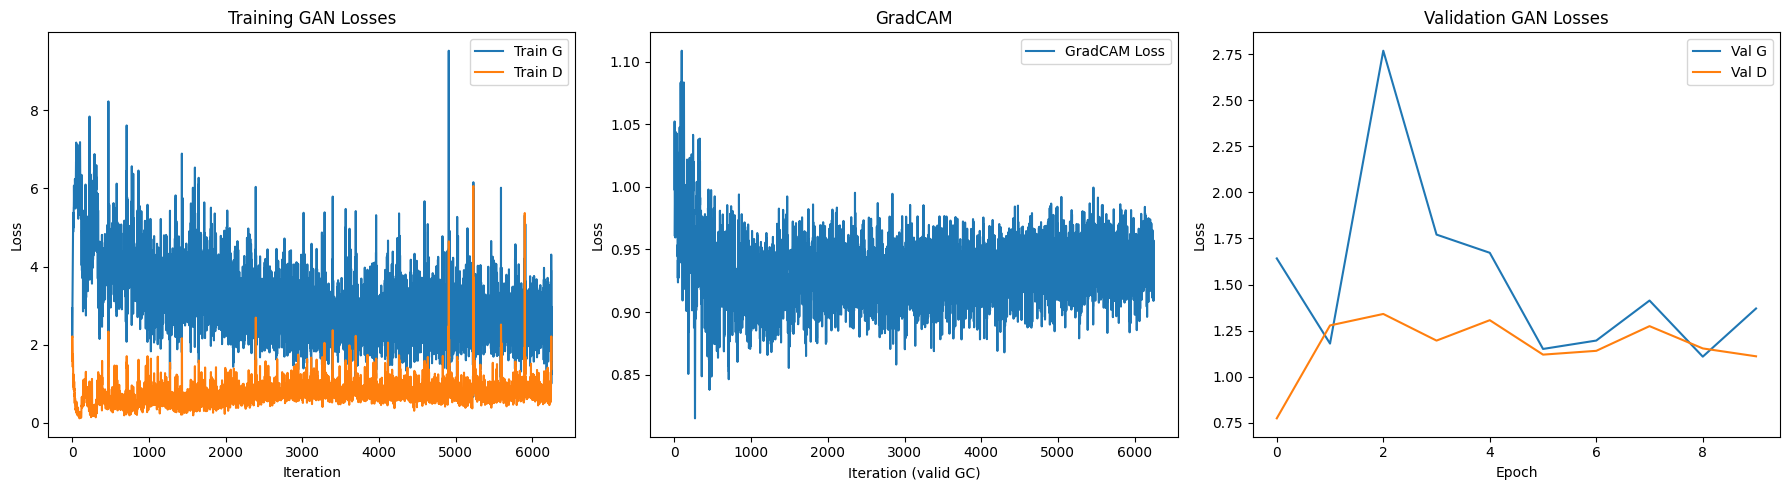

Step 6: Evaluating GAN with GradCAM


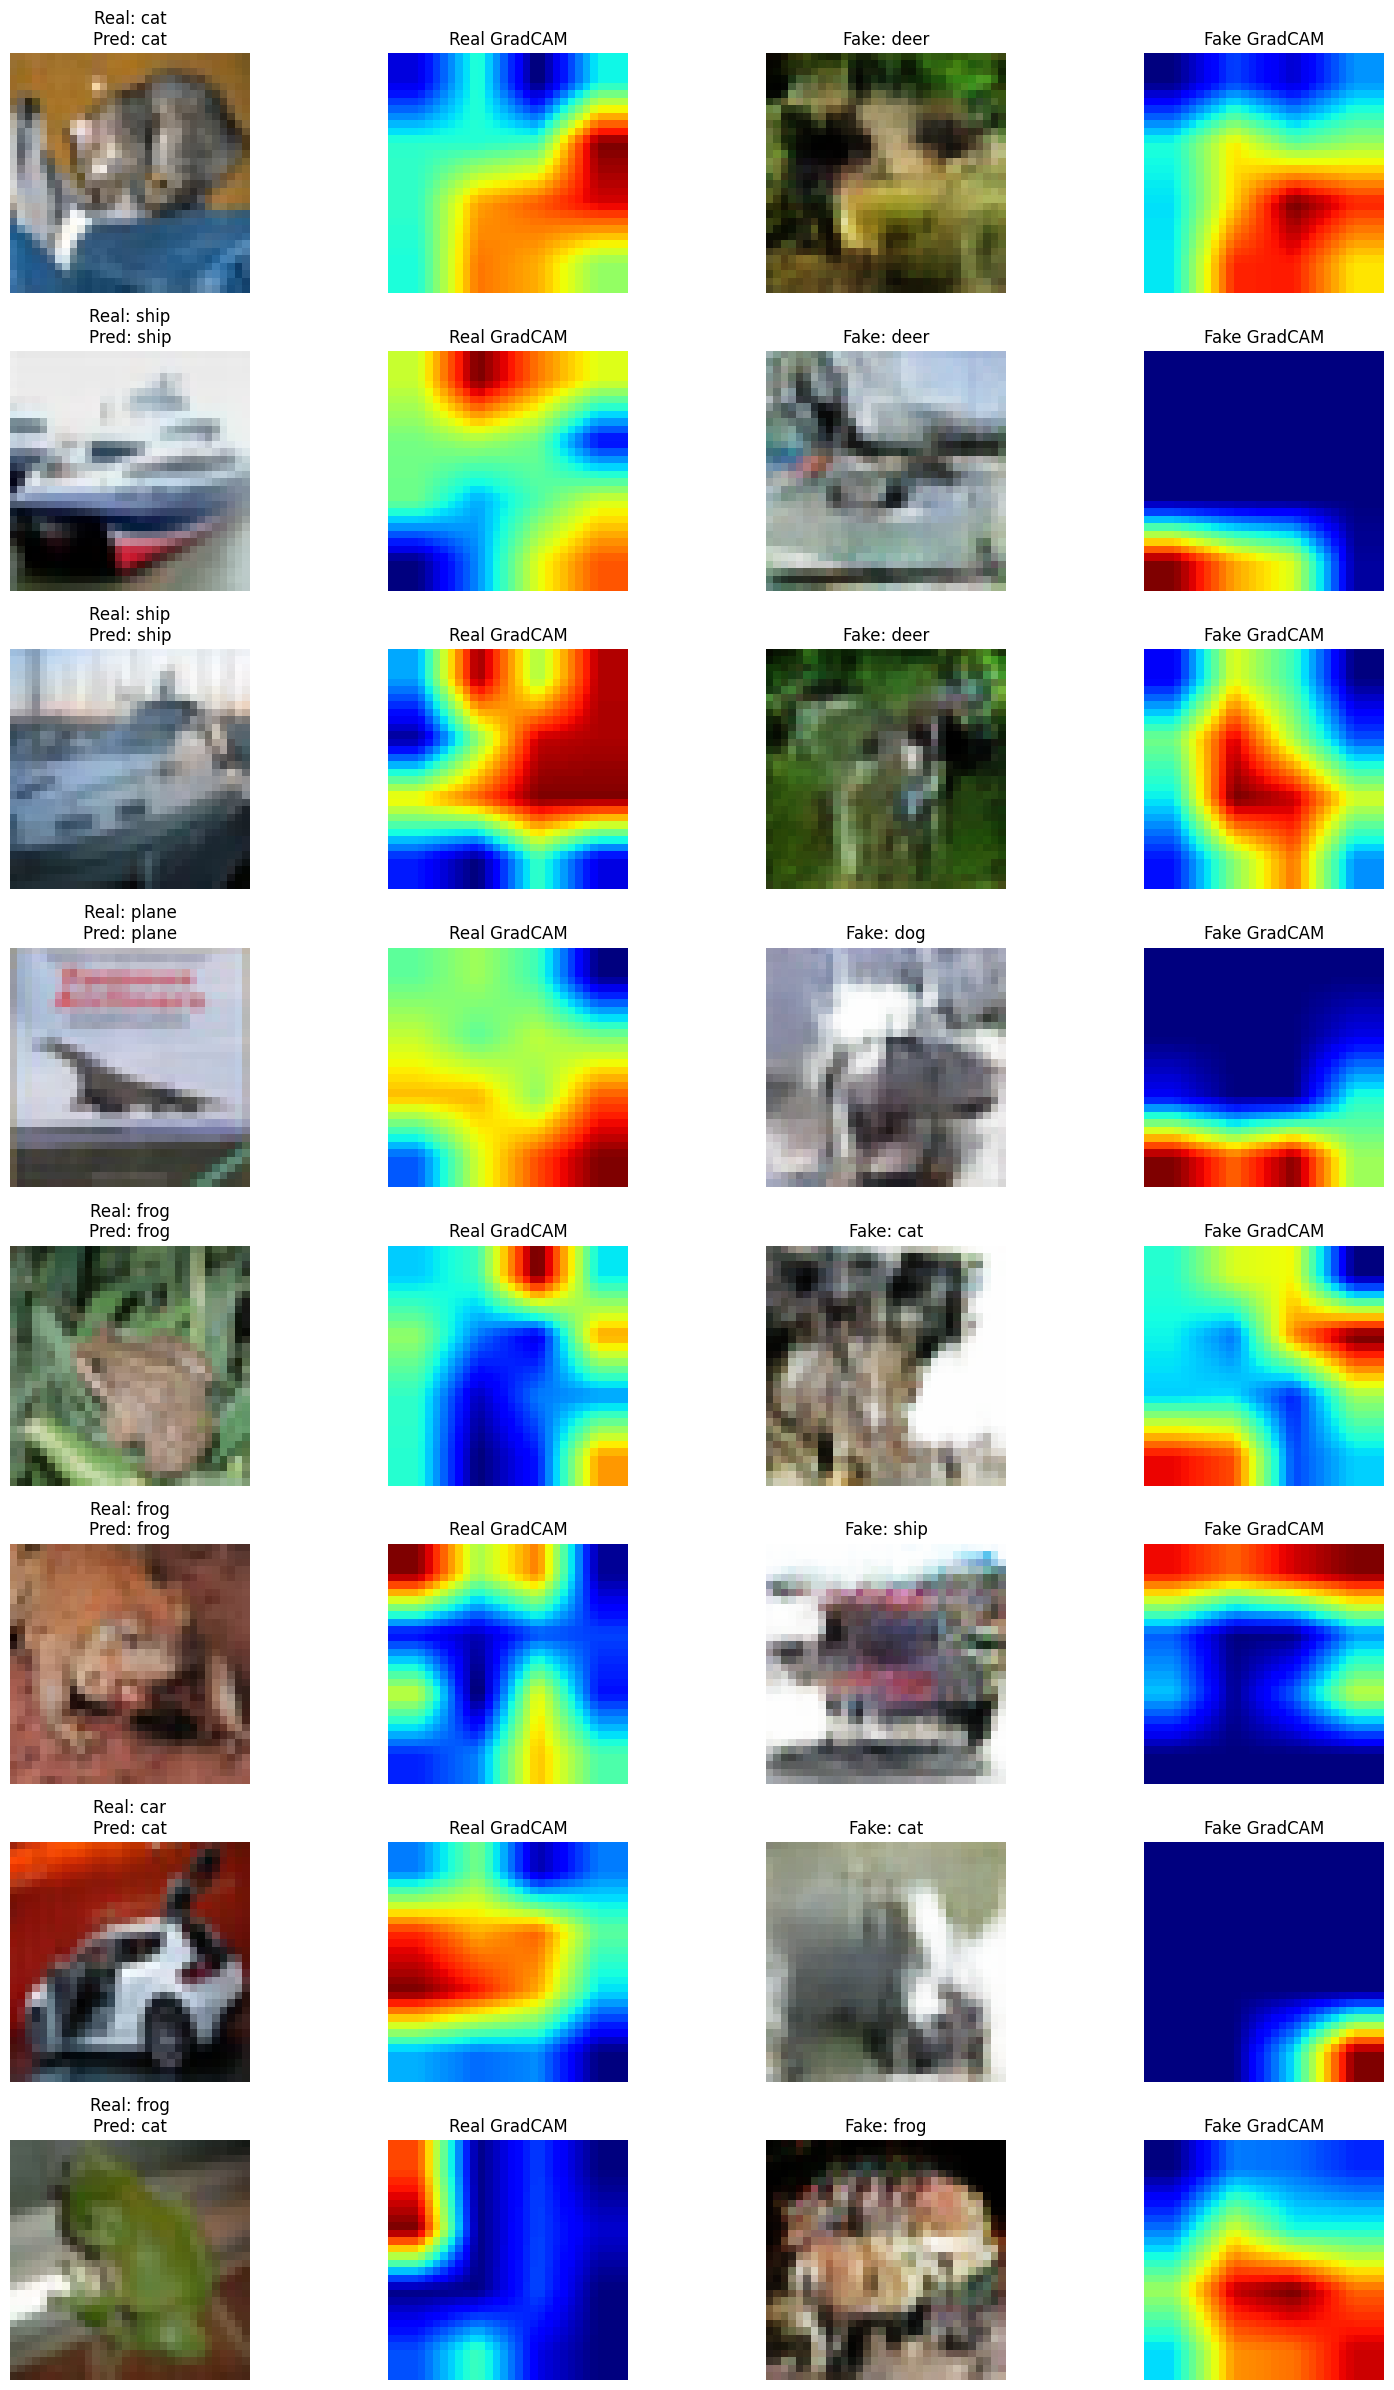

SSIM: Mean = 0.0290, Std = 0.0808
Pearson Correlation: Mean = 0.0430, Std = 0.3611


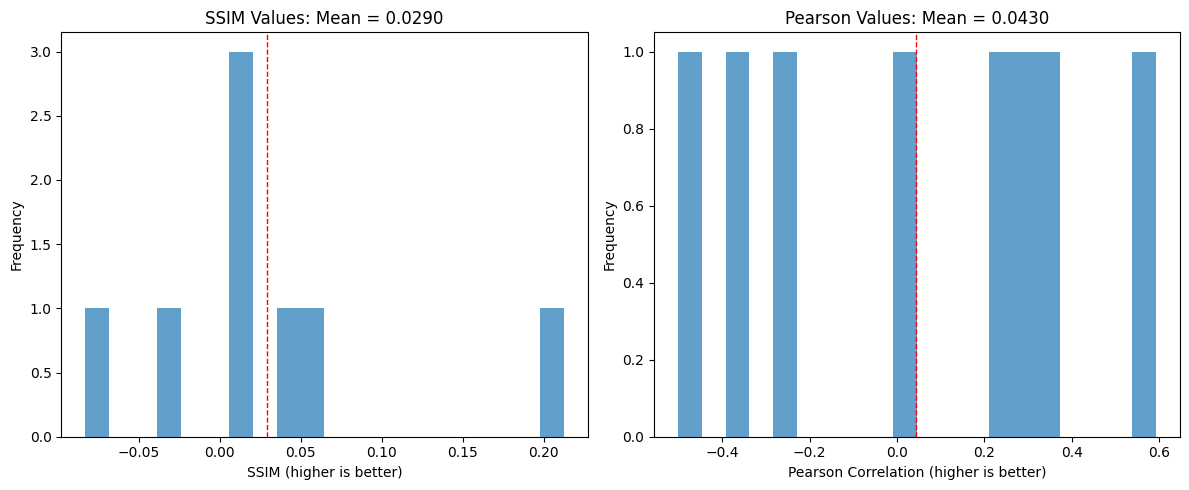

Step 7: Generating Final Samples


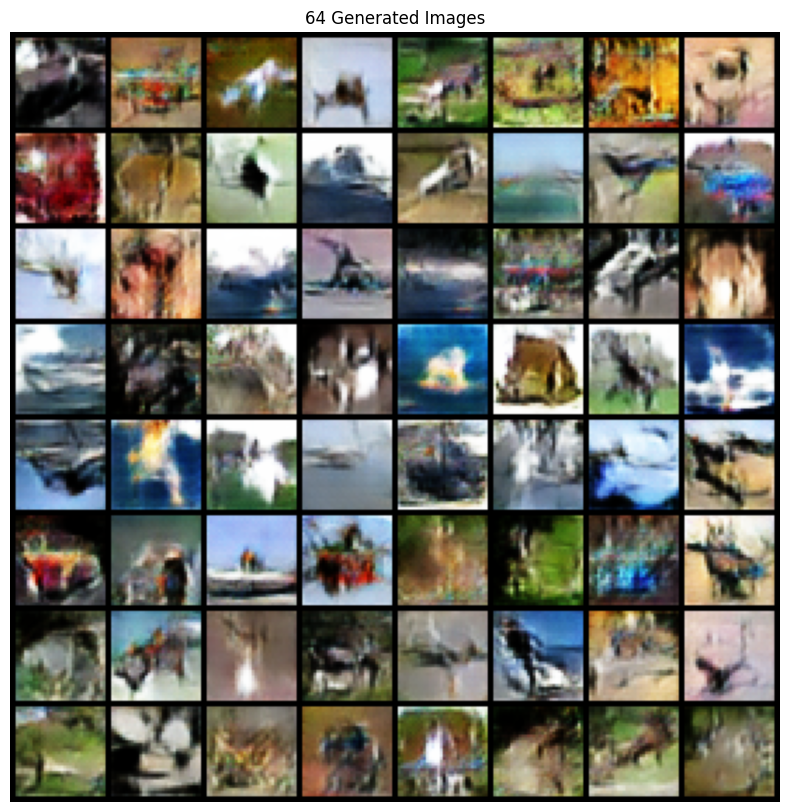

All steps completed!


In [11]:
main()

## Lambda = 0.5

In [12]:
# Standard imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
import os
import pickle
from tqdm import tqdm
import random

# PyTorch GradCAM imports
from pytorch_grad_cam import GradCAM as PyTorchGradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
batch_size = 64
image_size = 32
nc = 3  # Number of channels in the training images
nz = 100  # Size of z latent vector
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
num_epochs = 10 #150
lr = 0.0002
beta1 = 0.5  # Beta1 hyperparameter for Adam optimizer
lambda_gradcam = 0.5  # Weight for GradCAM loss 0.5, 0.7, 1.0 are the three options

# Create output directory for results
os.makedirs('results', exist_ok=True)
print('done')

Using device: cuda
done


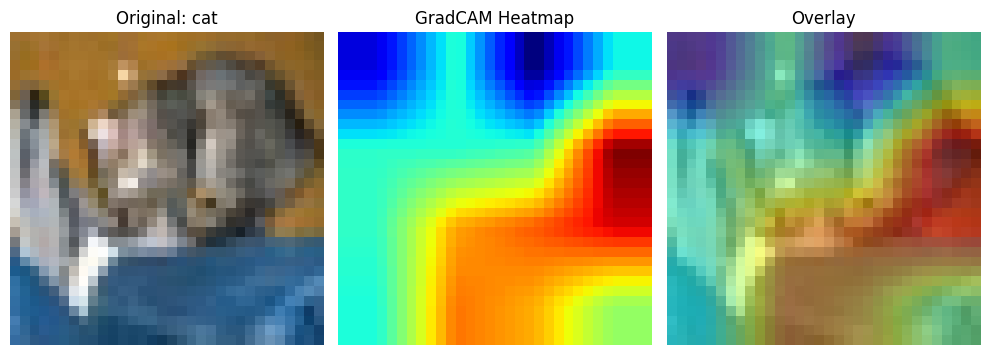

GradCAM test complete!


In [13]:
# Initialize GradCAM with the pre-trained model
# Note: Removed the use_cuda parameter that was causing the error
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

cam = GradCAM(
    model=model,  # Your pre-trained MobileNetV2
    target_layers=[last_conv_layer]  # The last conv layer you identified
)

# Function to generate Grad-CAM heatmaps
def generate_gradcam_heatmap(image, class_idx):
    try:
        # Detach from computation graph before converting to NumPy
        image_np = image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        # Normalize and preprocess for Grad-CAM
        input_tensor = preprocess_image(image_np, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        
        # Wrap class_idx properly
        target = [ClassifierOutputTarget(class_idx)]
        
        grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0]
        return grayscale_cam
    except Exception as e:
        print(f"Error in generate_gradcam_heatmap: {e}")
        # Return a fallback heatmap (uniform distribution)
        return np.ones((32, 32), dtype=np.float32) * 0.5
        
# Function to visualize GradCAM heatmaps
def visualize_gradcam(model, images, labels=None, classes=None):
    """Visualize GradCAM heatmaps for a batch of images"""
    model.eval()
    plt.figure(figsize=(15, 4*len(images)))
    
    for i, image in enumerate(images):
        # Process image
        img_tensor = image.unsqueeze(0).to(device)
        
        # Get prediction if labels not provided
        if labels is None:
            with torch.no_grad():
                output = model(img_tensor)
                _, pred = torch.max(output, 1)
                pred = pred.item()
        else:
            # Just use the label directly - no need to call .item() as we already did that in main()
            pred = labels[i]
        
        # Generate heatmap
        heatmap = generate_gradcam_heatmap(img_tensor, pred)
        
        # Display original image
        plt.subplot(len(images), 3, i*3+1)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
        if classes:
            plt.title(f'Class: {classes[pred]}')
        else:
            plt.title(f'Class: {pred}')
        plt.axis('off')
        
        # Display heatmap
        plt.subplot(len(images), 3, i*3+2)
        plt.imshow(heatmap, cmap='jet')
        plt.title('GradCAM Heatmap')
        plt.axis('off')
        
        # Display overlay
        plt.subplot(len(images), 3, i*3+3)
        img_np = image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
        plt.imshow(img_np)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
# Test the GradCAM function with a sample image
def test_gradcam():
    # Get a sample image
    test_batch = next(iter(testloader))
    test_image = test_batch[0][0].unsqueeze(0).to(device)
    test_label = test_batch[1][0].item()
    
    # Generate heatmap
    heatmap = generate_gradcam_heatmap(test_image, test_label)
    
    # Display the results
    plt.figure(figsize=(10, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    img_np = test_image.squeeze().cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
    plt.imshow(img_np)
    plt.title(f'Original: {classes[test_label]}')
    plt.axis('off')
    
    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('GradCAM Heatmap')
    plt.axis('off')
    
    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(img_np)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title('Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("GradCAM test complete!")
    return heatmap

# Function to generate class-specific GradCAM heatmaps
def generate_class_heatmaps(model, dataloader, num_samples=50):
    """Generate and store GradCAM heatmaps for each class"""
    class_heatmaps = {i: [] for i in range(10)}  # 10 classes in CIFAR-10
    
    model.eval()
    count = {i: 0 for i in range(10)}
    
    for data in tqdm(dataloader, desc="Generating class heatmaps"):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        for i in range(images.size(0)):
            label = labels[i].item()
            
            if count[label] < num_samples:
                image = images[i:i+1]
                
                # Get prediction
                with torch.no_grad():
                    output = model(image)
                    _, predicted = torch.max(output, 1)
                
                # Only use correctly classified images
                if predicted.item() == label:
                    try:
                        # Generate heatmap
                        heatmap = generate_gradcam_heatmap(image, label)
                        
                        # Convert to tensor
                        heatmap_tensor = torch.from_numpy(heatmap).float().unsqueeze(0).unsqueeze(0)
                        
                        class_heatmaps[label].append(heatmap_tensor)
                        count[label] += 1
                    except Exception as e:
                        print(f"Error generating heatmap: {e}")
                        continue
        
        # Check if we have enough samples for each class
        if all(count[i] >= num_samples for i in range(10)):
            break
    
    print(f"Generated heatmaps: {[len(class_heatmaps[i]) for i in range(10)]}")
    return class_heatmaps
    
# Uncomment to test the GradCAM function
test_result = test_gradcam()

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input.view(-1, nz, 1, 1))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            # No Sigmoid here, will use BCEWithLogitsLoss
        )

    def forward(self, input):
        return self.main(input)

# Initialize networks
def initialize_networks():
    """Initialize Generator and Discriminator networks"""
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    
    # Initialize weights
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    return netG, netD

In [15]:
# GAN Training with GradCAM (5-sample heatmap comparison)
def train_gan_with_gradcam(pretrained_model, class_heatmaps, netG, netD, num_epochs=50):
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    fixed_noise = torch.randn(16, nz, 1, 1, device=device)

    g_losses, d_losses, gc_losses = [], [], []
    val_g_losses, val_d_losses, val_gc_losses = [], [], []

    for epoch in range(num_epochs):
        netG.train()
        netD.train()
        for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            real_images, _ = data
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # ---- Train Discriminator ----
            netD.zero_grad()
            label = torch.full((batch_size,), 1., device=device)
            output = netD(real_images).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()

            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            label.fill_(0.)
            output = netD(fake_images.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optimizerD.step()

            # ---- Train Generator ----
            netG.zero_grad()
            label.fill_(1.)
            output = netD(fake_images).view(-1)
            errG_gan = criterion(output, label)

            pretrained_model.eval()
            with torch.no_grad():
                logits = pretrained_model(fake_images)
                preds = logits.argmax(dim=1)

            gradcam_loss_value = 0.
            valid_count = 0
            for j in range(batch_size):
                cls = preds[j].item()
                if class_heatmaps[cls] and len(class_heatmaps[cls]) >= 5:
                    try:
                        hm = generate_gradcam_heatmap(fake_images[j:j+1], cls)
                        fake_hm = torch.from_numpy(hm).float().unsqueeze(0).unsqueeze(0).to(device)

                        real_hms = random.sample(class_heatmaps[cls], k=5)
                        losses = [gradcam_region_emphasis_loss(r.to(device), fake_hm) for r in real_hms]
                        gradcam_loss_value += sum(losses) / len(losses)
                        valid_count += 1
                    except Exception as e:
                        print(f"skipping heatmap: {e}")

            if valid_count > 0:
                gradcam_loss_value /= valid_count
                gc_losses.append(gradcam_loss_value.item())
            else:
                gradcam_loss_value = 0.
                print("gradcam_loss_value is zero")

            errG = errG_gan + lambda_gradcam * gradcam_loss_value
            errG.backward()
            optimizerG.step()

            g_losses.append(errG.item())
            d_losses.append(errD.item())

            if i % 50 == 0:
                print(f"[{epoch+1}/{num_epochs}][{i}/{len(trainloader)}] "
                      f"Loss_D: {errD.item():.4f}, Loss_G: {errG.item():.4f}, GC: {gradcam_loss_value:.4f}")
                
        print(f"==> Epoch {epoch+1} TRAIN Losses | D: {errD.item():.4f} | G: {errG.item():.4f} | GC: {gradcam_loss_value:.4f}")

        # ---- Validation pass at end of epoch ----
        # === validation pass ===
        netG.eval(); netD.eval()
        run_d, run_g = 0., 0.
        n_batches = 0

        # 1) GAN val losses (no grad)
        with torch.no_grad():
            for real_images, _ in valloader:
                real_images = real_images.to(device)
                bs = real_images.size(0)

                # D‐val
                lbl = torch.full((bs,), 1., device=device)
                r_out = netD(real_images).view(-1)
                eDr = criterion(r_out, lbl)

                noise = torch.randn(bs, nz, 1, 1, device=device)
                f_imgs = netG(noise)
                lbl.fill_(0.)
                f_out = netD(f_imgs).view(-1)
                eDf = criterion(f_out, lbl)

                run_d += (eDr + eDf).item()

                # G‐val (GAN component)
                lbl.fill_(1.)
                eGv = criterion(netD(f_imgs).view(-1), lbl)
                run_g += eGv.item()

                n_batches += 1

        val_d_losses.append(run_d / n_batches)
        val_g_losses.append(run_g / n_batches)

        # 2) GradCAM val loss (with grad)
        run_gc = 0.
        valid_batches = 0
        for _, _ in valloader:
            # regenerate fakes WITH grad
            noise = torch.randn(bs, nz, 1, 1, device=device)
            fake_images = netG(noise)
            fake_images.requires_grad_(True)

            # forward through pretrained with grad enabled
            pretrained_model.eval()
            with torch.enable_grad():
                logits = pretrained_model(fake_images)
                preds = logits.argmax(dim=1)

            # compute per-sample GradCAM
            batch_gc = 0.
            cnt = 0
            for j in range(bs):
                cls = preds[j].item()
                if class_heatmaps[cls] and len(class_heatmaps[cls]) >= 5:
                    try:
                        hm = generate_gradcam_heatmap(fake_images[j:j+1], cls)
                        fake_hm = (torch.from_numpy(hm)
                                        .float()
                                        .unsqueeze(0)
                                        .unsqueeze(0)
                                        .to(device))
                        real_hms = random.sample(class_heatmaps[cls], k=5)
                        losses = [gradcam_region_emphasis_loss(r.to(device), fake_hm)
                                  for r in real_hms]
                        batch_gc += sum(losses) / len(losses)
                        cnt += 1
                    except Exception as e:
                        print(f"val GC skip: {e}")

            if cnt > 0:
                run_gc += batch_gc.item() / cnt
                valid_batches += 1

        # average and record
        if valid_batches > 0:
            val_gc_losses.append(run_gc / valid_batches)
        else:
            val_gc_losses.append(0.)

        print(f"==> Epoch {epoch+1} VAL | D: {val_d_losses[-1]:.4f} | "
              f"G: {val_g_losses[-1]:.4f} | GC: {val_gc_losses[-1]:.4f}")

        # ---- Save samples every 5 epochs ----
        if (epoch+1) % 5 == 0 or epoch == num_epochs-1:
            with torch.no_grad():
                samples = netG(fixed_noise).cpu()
            save_image(make_grid(samples, padding=2, normalize=True),
                       f'results/fake_samples_0_5_epoch_{epoch+1}.png')
            print(f"Saved samples at epoch {epoch+1}")

    # ---- final save ----
    torch.save(netG.state_dict(), 'results/generator0_5.pth')
    torch.save(netD.state_dict(), 'results/discriminator0_5.pth')

    # ---- Plotting ----
    plt.figure(figsize=(18, 5))

    # 1) train G vs D
    plt.subplot(1, 3, 1)
    plt.plot(g_losses, label='Train G')
    plt.plot(d_losses, label='Train D')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training GAN Losses')

    # 2) GradCAM loss
    plt.subplot(1, 3, 2)
    if gc_losses:
        plt.plot(gc_losses, label='GradCAM Loss')
        plt.xlabel('Iteration (valid GC)')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('GradCAM')

    # 3) validation G vs D
    plt.subplot(1, 3, 3)
    plt.plot(val_g_losses, label='Val G')
    plt.plot(val_d_losses, label='Val D')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Validation GAN Losses')

    plt.tight_layout()
    plt.savefig('results/gan_loss_curves0_5.png')
    plt.show()

    return netG, netD, g_losses, d_losses, gc_losses, val_g_losses, val_d_losses

In [16]:
# Evaluation and Visualization Functions
def compare_real_fake_heatmaps(pretrained_model, netG, testloader, classes, n_samples=8):
    """Compare GradCAM heatmaps between real and generated images using pre-trained model"""
    pretrained_model.eval()
    netG.eval()
    
    # Get a batch of real images
    real_batch = next(iter(testloader))
    real_images = real_batch[0][:n_samples].to(device)
    real_labels = real_batch[1][:n_samples].to(device)
    
    # Generate fake images
    noise = torch.randn(n_samples, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_images = netG(noise)
    
    # Generate and compare heatmaps
    plt.figure(figsize=(16, 3*n_samples))
    
    for i in range(n_samples):
        # Real image
        real_image = real_images[i:i+1]
        real_label = real_labels[i].item()
        
        # Get prediction for real image
        with torch.no_grad():
            real_output = pretrained_model(real_image)
            _, real_pred = torch.max(real_output, 1)
            real_pred = real_pred.item()
        
        # Generate heatmap for real image
        real_heatmap = generate_gradcam_heatmap(real_image, real_pred)
        
        # Fake image
        fake_image = fake_images[i:i+1]
        
        # Get prediction for fake image
        with torch.no_grad():
            fake_output = pretrained_model(fake_image)
            _, fake_pred = torch.max(fake_output, 1)
            fake_pred = fake_pred.item()
        
        # Generate heatmap for fake image
        fake_heatmap = generate_gradcam_heatmap(fake_image, fake_pred)
        
        # Plot real image and its heatmap
        plt.subplot(n_samples, 4, i*4+1)
        plt.imshow(real_image.cpu().squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(f'Real: {classes[real_label]}\nPred: {classes[real_pred]}')
        plt.axis('off')
        
        plt.subplot(n_samples, 4, i*4+2)
        plt.imshow(real_heatmap, cmap='jet')
        plt.title('Real GradCAM')
        plt.axis('off')
        
        # Plot fake image and its heatmap
        plt.subplot(n_samples, 4, i*4+3)
        plt.imshow(fake_image.cpu().squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5)
        plt.title(f'Fake: {classes[fake_pred]}')
        plt.axis('off')
        
        plt.subplot(n_samples, 4, i*4+4)
        plt.imshow(fake_heatmap, cmap='jet')
        plt.title('Fake GradCAM')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/gradcam_comparison0_5.png')
    plt.show()
    
    return real_images, fake_images

# Function to calculate metrics between real and fake heatmaps
def calculate_heatmap_metrics(pretrained_model, real_images, fake_images, n_samples=100):
    """Calculate metrics between real and fake GradCAM heatmaps"""
    pretrained_model.eval()
    
    ssim_values = []
    pearson_values = []
    
    for i in range(min(len(real_images), len(fake_images), n_samples)):
        try:
            # Real image
            real_image = real_images[i:i+1].to(device)
            
            # Get prediction for real image
            with torch.no_grad():
                real_output = pretrained_model(real_image)
                _, real_pred = torch.max(real_output, 1)
                real_pred = real_pred.item()
            
            # Generate heatmap for real image
            real_heatmap_np = generate_gradcam_heatmap(real_image, real_pred)
            real_heatmap = torch.from_numpy(real_heatmap_np).float().unsqueeze(0).unsqueeze(0)
            
            # Fake image
            fake_image = fake_images[i:i+1].to(device)
            
            # Generate heatmap for fake image - use same class as real for comparison
            fake_heatmap_np = generate_gradcam_heatmap(fake_image, real_pred)
            fake_heatmap = torch.from_numpy(fake_heatmap_np).float().unsqueeze(0).unsqueeze(0)
            
            # Calculate metrics
            ssim_val = 1.0 - ssim_loss(real_heatmap, fake_heatmap)  # Convert loss to similarity
            pearson_val = 1.0 - pearson_loss(real_heatmap, fake_heatmap)  # Convert loss to similarity
            
            ssim_values.append(ssim_val)
            pearson_values.append(pearson_val)
        except Exception as e:
            print(f"Error calculating metrics for sample {i}: {e}")
            continue
    
    # Calculate statistics
    if ssim_values and pearson_values:
        ssim_mean = np.mean(ssim_values)
        ssim_std = np.std(ssim_values)
        pearson_mean = np.mean(pearson_values)
        pearson_std = np.std(pearson_values)
        
        print(f"SSIM: Mean = {ssim_mean:.4f}, Std = {ssim_std:.4f}")
        print(f"Pearson Correlation: Mean = {pearson_mean:.4f}, Std = {pearson_std:.4f}")
        
        # Plot histogram of values
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(ssim_values, bins=20, alpha=0.7)
        plt.axvline(ssim_mean, color='r', linestyle='dashed', linewidth=1)
        plt.title(f'SSIM Values: Mean = {ssim_mean:.4f}')
        plt.xlabel('SSIM (higher is better)')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 2, 2)
        plt.hist(pearson_values, bins=20, alpha=0.7)
        plt.axvline(pearson_mean, color='r', linestyle='dashed', linewidth=1)
        plt.title(f'Pearson Values: Mean = {pearson_mean:.4f}')
        plt.xlabel('Pearson Correlation (higher is better)')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.savefig('results/heatmap_metrics0_5.png')
        plt.show()
        
        return {
            'ssim_mean': ssim_mean,
            'ssim_std': ssim_std,
            'pearson_mean': pearson_mean,
            'pearson_std': pearson_std,
            'ssim_values': ssim_values,
            'pearson_values': pearson_values
        }
    else:
        print("Not enough valid samples to calculate metrics")
        return None

# Function to generate samples with the trained generator
def generate_samples(netG, n_samples=100, n_display=64):
    """Generate samples using the trained generator"""
    netG.eval()
    
    # Generate images
    noise = torch.randn(n_samples, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_images = netG(noise).detach().cpu()
    
    # Display a subset of generated images
    if n_display > 0:
        plt.figure(figsize=(10, 10))
        plt.axis('off')
        plt.title(f"{n_display} Generated Images")
        plt.imshow(np.transpose(make_grid(fake_images[:n_display], 
                                        padding=2, normalize=True), (1, 2, 0)))
        plt.savefig('results/final_samples0_5.png')
        plt.show()
    
    return fake_images

In [17]:
# Main execution function
def main_2():

    print("Step 1: Setting up pre-trained classifier")
    # Pre-trained model and GradCAM are already set up (model & cam variables)
    
    print("Step 2: Testing GradCAM visualization")
    # Test GradCAM with a few images
    test_batch = next(iter(testloader))
    test_images, test_labels = test_batch
    
    # Convert tensor labels to Python integers before passing to visualize_gradcam
    test_labels_list = [label.item() for label in test_labels[:5]]
    visualize_gradcam(model, test_images[:5], test_labels_list, classes)
    
    print("Step 3: Generating Class-Specific GradCAM Heatmaps")
    # Try loading existing heatmaps first
    try:
        with open('results/class_heatmaps0_5.pkl', 'rb') as f:
            class_heatmaps = pickle.load(f)
        print("Loaded existing heatmaps from disk")
    except:
        print("Generating new heatmaps")
        class_heatmaps = generate_class_heatmaps(model, trainloader, num_samples=50)
        # Save heatmaps to avoid regenerating them
        os.makedirs('results', exist_ok=True)
        with open('results/class_heatmaps0_5.pkl', 'wb') as f:
            pickle.dump(class_heatmaps, f)
        print("Saved heatmaps to disk")
    
    print("Step 4: Initializing GAN Networks")
    netG, netD = initialize_networks()
    
    print("Step 5: Training GAN with GradCAM Guidance")
    # You can adjust the number of epochs based on your computational resources
    netG, netD, g_losses, d_losses, gc_losses, val_g_losses, val_d_losses = train_gan_with_gradcam(model, class_heatmaps, netG, netD, num_epochs=num_epochs)
    
    print("Step 6: Evaluating GAN with GradCAM")
    real_images, fake_images = compare_real_fake_heatmaps(model, netG, testloader, classes)
    metrics = calculate_heatmap_metrics(model, real_images, fake_images)
    
    print("Step 7: Generating Final Samples")
    generated_samples = generate_samples(netG, n_samples=100)
    
    print("All steps completed!")

Step 1: Setting up pre-trained classifier
Step 2: Testing GradCAM visualization


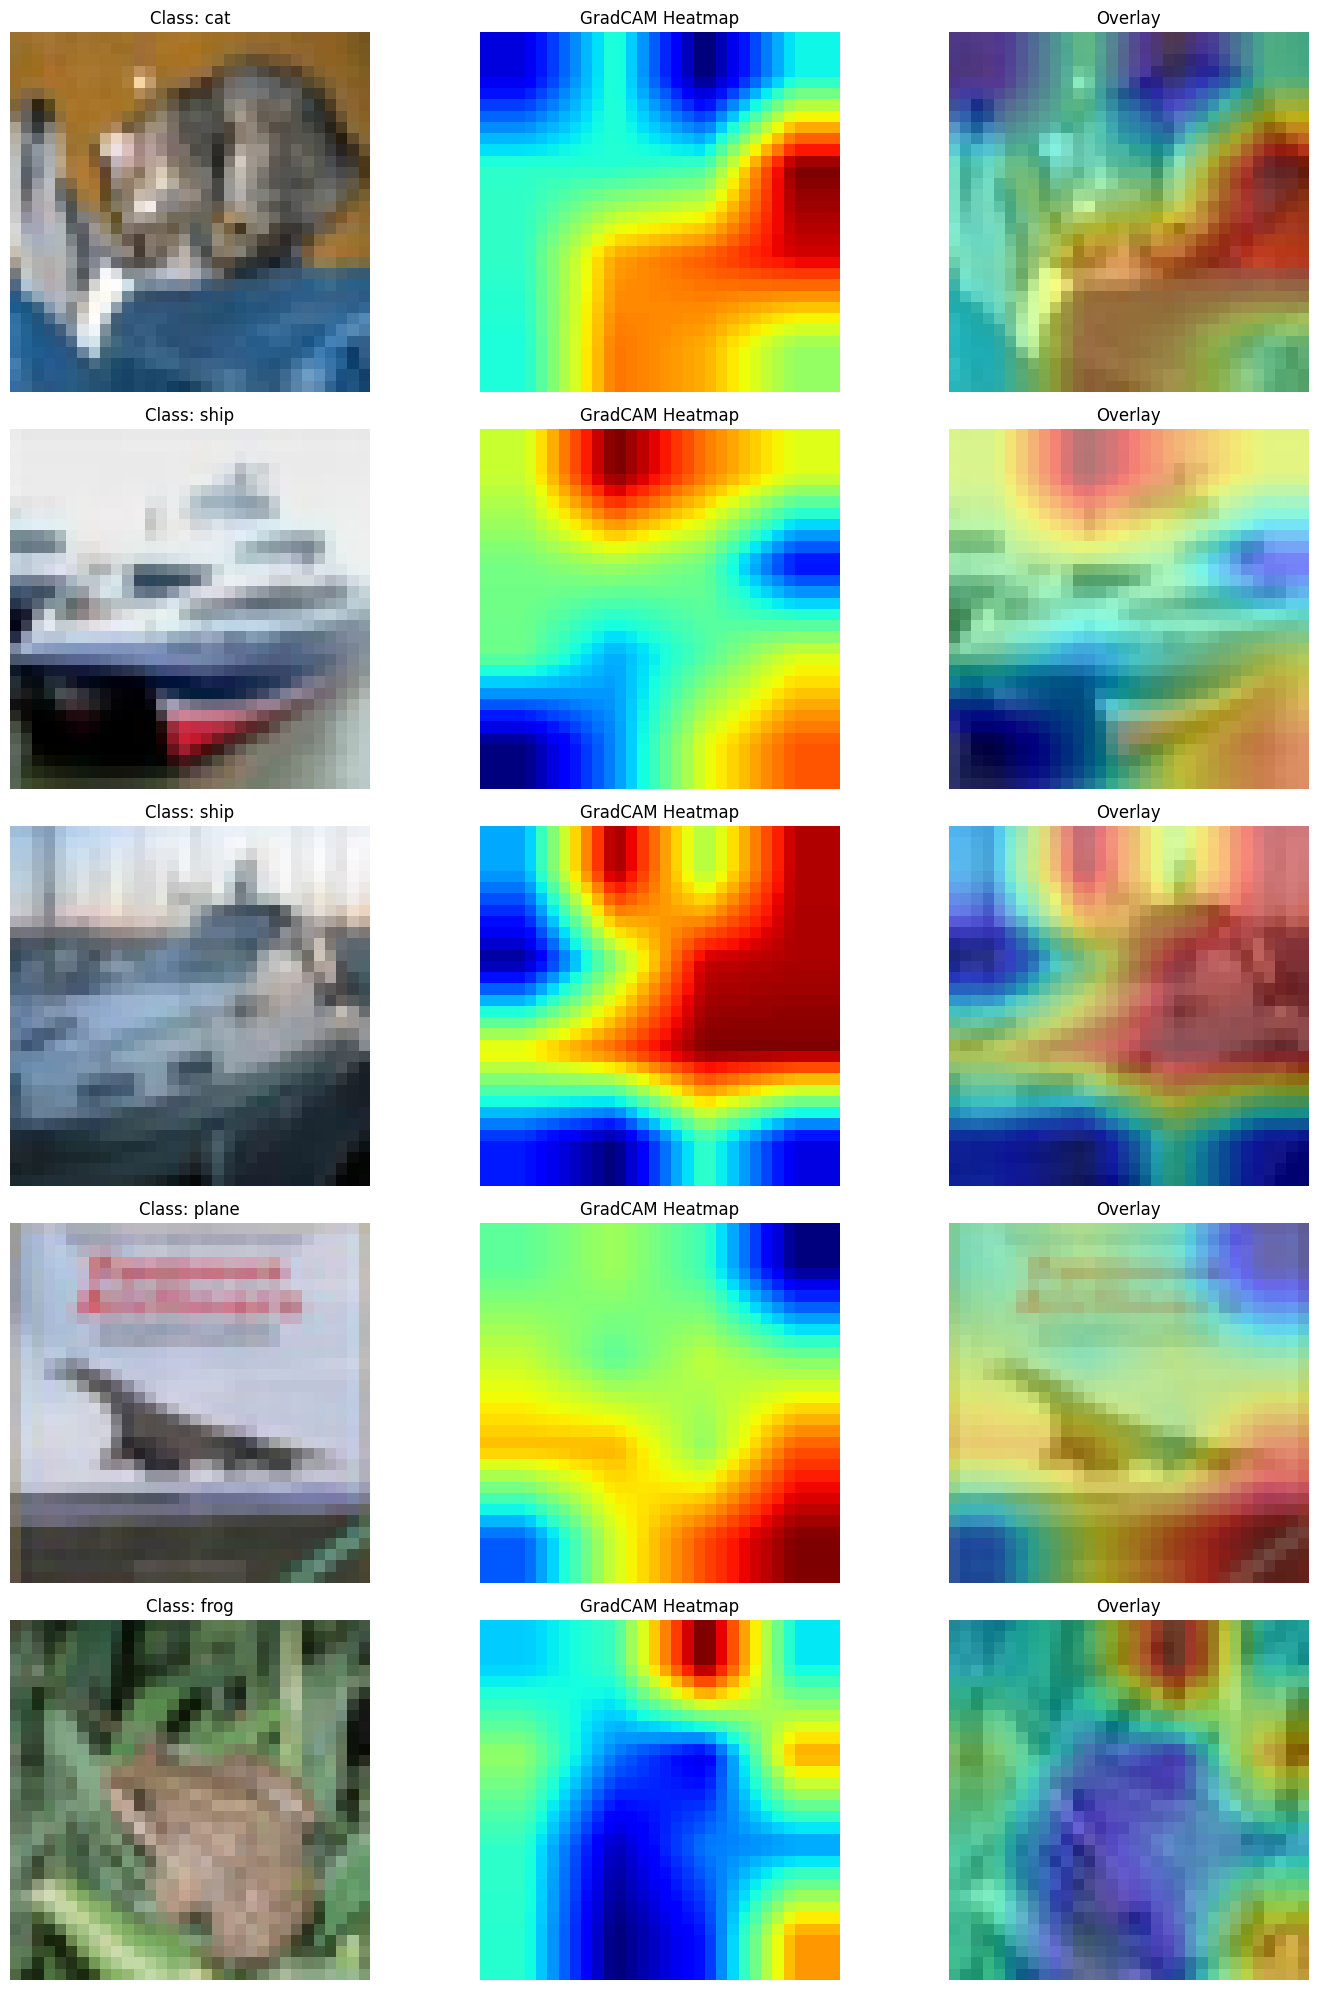

Step 3: Generating Class-Specific GradCAM Heatmaps
Generating new heatmaps


Generating class heatmaps:   2%|▏         | 12/625 [00:16<13:53,  1.36s/it]


Generated heatmaps: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Saved heatmaps to disk
Step 4: Initializing GAN Networks
Step 5: Training GAN with GradCAM Guidance


Epoch 1/10:   0%|          | 1/625 [00:02<27:26,  2.64s/it]

[1/10][0/625] Loss_D: 1.5697, Loss_G: 2.7769, GC: 1.0197


Epoch 1/10:   8%|▊         | 51/625 [02:02<23:36,  2.47s/it]

[1/10][50/625] Loss_D: 0.3148, Loss_G: 6.1488, GC: 0.9898


Epoch 1/10:  16%|█▌        | 101/625 [03:57<20:26,  2.34s/it]

[1/10][100/625] Loss_D: 0.1129, Loss_G: 5.9871, GC: 1.1319


Epoch 1/10:  24%|██▍       | 151/625 [05:55<19:35,  2.48s/it]

[1/10][150/625] Loss_D: 0.6645, Loss_G: 3.8213, GC: 0.9329


Epoch 1/10:  32%|███▏      | 201/625 [07:55<17:18,  2.45s/it]

[1/10][200/625] Loss_D: 0.4702, Loss_G: 4.1408, GC: 1.0453


Epoch 1/10:  32%|███▏      | 202/625 [07:58<17:37,  2.50s/it]/tmp/ipykernel_11997/346551886.py:22: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(img1_flat, img2_flat)
Epoch 1/10:  40%|████      | 251/625 [09:54<14:08,  2.27s/it]

[1/10][250/625] Loss_D: 0.2682, Loss_G: 3.7505, GC: 1.0031


Epoch 1/10:  48%|████▊     | 301/625 [11:49<13:30,  2.50s/it]

[1/10][300/625] Loss_D: 0.1874, Loss_G: 4.9535, GC: 1.0025


Epoch 1/10:  56%|█████▌    | 351/625 [13:48<11:01,  2.41s/it]

[1/10][350/625] Loss_D: 0.1660, Loss_G: 5.1489, GC: 0.9800


Epoch 1/10:  64%|██████▍   | 401/625 [15:45<08:59,  2.41s/it]

[1/10][400/625] Loss_D: 1.4497, Loss_G: 2.7382, GC: 1.0079


Epoch 1/10:  72%|███████▏  | 451/625 [17:41<06:32,  2.25s/it]

[1/10][450/625] Loss_D: 0.9448, Loss_G: 3.7373, GC: 0.9603


Epoch 1/10:  80%|████████  | 501/625 [19:41<05:11,  2.51s/it]

[1/10][500/625] Loss_D: 1.0115, Loss_G: 2.9937, GC: 0.9038


Epoch 1/10:  88%|████████▊ | 551/625 [21:30<02:50,  2.30s/it]

[1/10][550/625] Loss_D: 0.6153, Loss_G: 3.4473, GC: 0.9412


Epoch 1/10:  96%|█████████▌| 601/625 [23:29<00:56,  2.34s/it]

[1/10][600/625] Loss_D: 0.4490, Loss_G: 4.3111, GC: 0.9755


Epoch 1/10: 100%|██████████| 625/625 [24:24<00:00,  2.34s/it]

==> Epoch 1 TRAIN Losses | D: 1.1295 | G: 4.3314 | GC: 0.9262


==> Epoch 1 VAL | D: 1.1122 | G: 1.9486 | GC: 0.9039


Epoch 2/10:   0%|          | 1/625 [00:02<27:13,  2.62s/it]

[2/10][0/625] Loss_D: 0.8797, Loss_G: 4.6831, GC: 0.9544


Epoch 2/10:   8%|▊         | 51/625 [02:03<23:47,  2.49s/it]

[2/10][50/625] Loss_D: 0.4022, Loss_G: 4.2495, GC: 0.9511


Epoch 2/10:  16%|█▌        | 101/625 [04:07<21:42,  2.49s/it]

[2/10][100/625] Loss_D: 0.5588, Loss_G: 3.6442, GC: 0.9514


Epoch 2/10:  24%|██▍       | 151/625 [05:49<16:39,  2.11s/it]

[2/10][150/625] Loss_D: 0.5132, Loss_G: 4.1494, GC: 0.9264


Epoch 2/10:  32%|███▏      | 201/625 [07:44<18:10,  2.57s/it]

[2/10][200/625] Loss_D: 0.2053, Loss_G: 4.3518, GC: 0.9489


Epoch 2/10:  40%|████      | 251/625 [09:40<12:58,  2.08s/it]

[2/10][250/625] Loss_D: 0.5845, Loss_G: 3.0084, GC: 0.9159


Epoch 2/10:  48%|████▊     | 301/625 [11:39<12:48,  2.37s/it]

[2/10][300/625] Loss_D: 0.5206, Loss_G: 3.2770, GC: 0.9418


Epoch 2/10:  56%|█████▌    | 351/625 [13:32<06:45,  1.48s/it]

[2/10][350/625] Loss_D: 0.7955, Loss_G: 4.7145, GC: 0.9449


Epoch 2/10:  64%|██████▍   | 401/625 [15:19<08:46,  2.35s/it]

[2/10][400/625] Loss_D: 0.5381, Loss_G: 2.8067, GC: 0.9725


Epoch 2/10:  72%|███████▏  | 451/625 [17:17<06:44,  2.33s/it]

[2/10][450/625] Loss_D: 0.8245, Loss_G: 3.8850, GC: 0.9007


Epoch 2/10:  80%|████████  | 501/625 [19:13<04:52,  2.36s/it]

[2/10][500/625] Loss_D: 0.5712, Loss_G: 3.8595, GC: 0.9625


Epoch 2/10:  88%|████████▊ | 551/625 [21:03<03:03,  2.48s/it]

[2/10][550/625] Loss_D: 0.5922, Loss_G: 3.1198, GC: 0.9442


Epoch 2/10:  96%|█████████▌| 601/625 [23:03<01:00,  2.50s/it]

[2/10][600/625] Loss_D: 0.9068, Loss_G: 2.0441, GC: 0.9284


Epoch 2/10: 100%|██████████| 625/625 [23:59<00:00,  2.30s/it]

==> Epoch 2 TRAIN Losses | D: 0.5873 | G: 2.8967 | GC: 0.9652


==> Epoch 2 VAL | D: 1.3476 | G: 1.0899 | GC: 0.9569


Epoch 3/10:   0%|          | 1/625 [00:02<28:09,  2.71s/it]

[3/10][0/625] Loss_D: 0.5481, Loss_G: 2.9055, GC: 1.0113


Epoch 3/10:   8%|▊         | 51/625 [01:54<23:02,  2.41s/it]

[3/10][50/625] Loss_D: 0.7585, Loss_G: 2.9129, GC: 0.9363


Epoch 3/10:  16%|█▌        | 101/625 [03:56<21:59,  2.52s/it]

[3/10][100/625] Loss_D: 0.7124, Loss_G: 2.5038, GC: 0.9468


Epoch 3/10:  24%|██▍       | 151/625 [05:59<18:14,  2.31s/it]

[3/10][150/625] Loss_D: 0.4972, Loss_G: 3.7305, GC: 0.9160


Epoch 3/10:  32%|███▏      | 201/625 [08:02<18:12,  2.58s/it]

[3/10][200/625] Loss_D: 0.5758, Loss_G: 3.4997, GC: 0.9593


Epoch 3/10:  40%|████      | 251/625 [09:57<15:12,  2.44s/it]

[3/10][250/625] Loss_D: 0.3921, Loss_G: 3.0265, GC: 0.9203


Epoch 3/10:  48%|████▊     | 301/625 [11:42<12:23,  2.30s/it]

[3/10][300/625] Loss_D: 0.5734, Loss_G: 2.9581, GC: 0.9554


Epoch 3/10:  56%|█████▌    | 351/625 [13:40<11:04,  2.43s/it]

[3/10][350/625] Loss_D: 0.7374, Loss_G: 2.2629, GC: 0.9512


Epoch 3/10:  64%|██████▍   | 401/625 [15:35<08:48,  2.36s/it]

[3/10][400/625] Loss_D: 0.7936, Loss_G: 2.5329, GC: 0.9073


Epoch 3/10:  72%|███████▏  | 451/625 [17:39<07:08,  2.46s/it]

[3/10][450/625] Loss_D: 0.4765, Loss_G: 3.2040, GC: 0.9248


Epoch 3/10:  80%|████████  | 501/625 [19:30<05:02,  2.44s/it]

[3/10][500/625] Loss_D: 0.4010, Loss_G: 3.0022, GC: 0.9354


Epoch 3/10:  88%|████████▊ | 551/625 [21:30<02:50,  2.31s/it]

[3/10][550/625] Loss_D: 1.0450, Loss_G: 5.2605, GC: 0.9105


Epoch 3/10:  96%|█████████▌| 601/625 [23:28<00:59,  2.50s/it]

[3/10][600/625] Loss_D: 1.0466, Loss_G: 2.6021, GC: 0.9440


Epoch 3/10: 100%|██████████| 625/625 [24:28<00:00,  2.35s/it]

==> Epoch 3 TRAIN Losses | D: 0.7660 | G: 2.3990 | GC: 0.9563


==> Epoch 3 VAL | D: 1.0930 | G: 1.1513 | GC: 0.9475


Epoch 4/10:   0%|          | 1/625 [00:02<25:09,  2.42s/it]

[4/10][0/625] Loss_D: 0.7193, Loss_G: 3.2825, GC: 0.9555


Epoch 4/10:   8%|▊         | 51/625 [02:00<23:14,  2.43s/it]

[4/10][50/625] Loss_D: 0.6042, Loss_G: 3.0370, GC: 0.9566


Epoch 4/10:  16%|█▌        | 101/625 [04:00<20:48,  2.38s/it]

[4/10][100/625] Loss_D: 0.7243, Loss_G: 3.8362, GC: 0.9671


Epoch 4/10:  24%|██▍       | 151/625 [05:58<19:22,  2.45s/it]

[4/10][150/625] Loss_D: 0.6676, Loss_G: 3.0797, GC: 0.9262


Epoch 4/10:  32%|███▏      | 201/625 [08:01<17:55,  2.54s/it]

[4/10][200/625] Loss_D: 0.7475, Loss_G: 3.3284, GC: 0.9207


Epoch 4/10:  40%|████      | 251/625 [09:50<15:08,  2.43s/it]

[4/10][250/625] Loss_D: 0.9224, Loss_G: 2.2527, GC: 0.9109


Epoch 4/10:  48%|████▊     | 301/625 [11:45<13:23,  2.48s/it]

[4/10][300/625] Loss_D: 0.6267, Loss_G: 3.6962, GC: 0.9498


Epoch 4/10:  56%|█████▌    | 351/625 [13:43<10:30,  2.30s/it]

[4/10][350/625] Loss_D: 1.0233, Loss_G: 3.5291, GC: 0.9307


Epoch 4/10:  64%|██████▍   | 401/625 [15:41<07:21,  1.97s/it]

[4/10][400/625] Loss_D: 0.8345, Loss_G: 3.6812, GC: 0.9519


Epoch 4/10:  72%|███████▏  | 451/625 [17:34<06:52,  2.37s/it]

[4/10][450/625] Loss_D: 1.0173, Loss_G: 1.4941, GC: 0.9419


Epoch 4/10:  80%|████████  | 501/625 [19:34<05:07,  2.48s/it]

[4/10][500/625] Loss_D: 0.8076, Loss_G: 2.3789, GC: 0.9300


Epoch 4/10:  88%|████████▊ | 551/625 [21:31<02:31,  2.04s/it]

[4/10][550/625] Loss_D: 0.5362, Loss_G: 3.1033, GC: 0.9499


Epoch 4/10:  96%|█████████▌| 601/625 [23:24<00:59,  2.47s/it]

[4/10][600/625] Loss_D: 0.5774, Loss_G: 2.3502, GC: 0.9304


Epoch 4/10: 100%|██████████| 625/625 [24:22<00:00,  2.34s/it]

==> Epoch 4 TRAIN Losses | D: 0.5711 | G: 2.5151 | GC: 0.9375


==> Epoch 4 VAL | D: 0.9752 | G: 1.4253 | GC: 0.9350


Epoch 5/10:   0%|          | 1/625 [00:02<27:19,  2.63s/it]

[5/10][0/625] Loss_D: 0.6544, Loss_G: 2.6236, GC: 0.9280


Epoch 5/10:   8%|▊         | 51/625 [01:59<21:36,  2.26s/it]

[5/10][50/625] Loss_D: 0.8416, Loss_G: 2.5580, GC: 0.9170


Epoch 5/10:  16%|█▌        | 101/625 [03:57<19:57,  2.29s/it]

[5/10][100/625] Loss_D: 0.7422, Loss_G: 2.8440, GC: 0.9265


Epoch 5/10:  24%|██▍       | 151/625 [05:57<19:56,  2.53s/it]

[5/10][150/625] Loss_D: 0.6783, Loss_G: 2.7882, GC: 0.9220


Epoch 5/10:  32%|███▏      | 201/625 [07:54<17:58,  2.54s/it]

[5/10][200/625] Loss_D: 0.5047, Loss_G: 3.3017, GC: 0.9400


Epoch 5/10:  40%|████      | 251/625 [09:49<15:05,  2.42s/it]

[5/10][250/625] Loss_D: 0.5681, Loss_G: 3.2948, GC: 0.8910


Epoch 5/10:  48%|████▊     | 301/625 [11:46<13:18,  2.47s/it]

[5/10][300/625] Loss_D: 1.2278, Loss_G: 3.0767, GC: 0.9540


Epoch 5/10:  56%|█████▌    | 351/625 [13:40<10:59,  2.41s/it]

[5/10][350/625] Loss_D: 0.7205, Loss_G: 2.8139, GC: 0.9296


Epoch 5/10:  64%|██████▍   | 401/625 [15:26<09:02,  2.42s/it]

[5/10][400/625] Loss_D: 0.6237, Loss_G: 2.6780, GC: 0.9116


Epoch 5/10:  72%|███████▏  | 451/625 [17:08<03:26,  1.19s/it]

[5/10][450/625] Loss_D: 1.3811, Loss_G: 1.7858, GC: 0.9189


Epoch 5/10:  80%|████████  | 501/625 [19:07<05:00,  2.42s/it]

[5/10][500/625] Loss_D: 0.8522, Loss_G: 1.9857, GC: 0.8866


Epoch 5/10:  88%|████████▊ | 551/625 [21:04<02:56,  2.38s/it]

[5/10][550/625] Loss_D: 0.9552, Loss_G: 2.7725, GC: 0.9248


Epoch 5/10:  96%|█████████▌| 601/625 [23:06<00:59,  2.46s/it]

[5/10][600/625] Loss_D: 1.0456, Loss_G: 2.5197, GC: 0.9474


Epoch 5/10: 100%|██████████| 625/625 [24:03<00:00,  2.31s/it]

==> Epoch 5 TRAIN Losses | D: 0.7966 | G: 1.8279 | GC: 0.9543


==> Epoch 5 VAL | D: 1.0523 | G: 1.0201 | GC: 0.9451
Saved samples at epoch 5


Epoch 6/10:   0%|          | 1/625 [00:02<24:02,  2.31s/it]

[6/10][0/625] Loss_D: 0.8331, Loss_G: 2.5844, GC: 0.9041


Epoch 6/10:   8%|▊         | 51/625 [01:57<17:16,  1.81s/it]

[6/10][50/625] Loss_D: 1.0346, Loss_G: 3.7109, GC: 0.9378


Epoch 6/10:  16%|█▌        | 101/625 [03:52<19:49,  2.27s/it]

[6/10][100/625] Loss_D: 0.9687, Loss_G: 1.6861, GC: 0.9166


Epoch 6/10:  24%|██▍       | 151/625 [05:52<19:39,  2.49s/it]

[6/10][150/625] Loss_D: 1.1517, Loss_G: 4.1858, GC: 0.9373


Epoch 6/10:  32%|███▏      | 201/625 [07:49<16:41,  2.36s/it]

[6/10][200/625] Loss_D: 0.7848, Loss_G: 2.1359, GC: 0.9046


Epoch 6/10:  40%|████      | 251/625 [09:46<13:24,  2.15s/it]

[6/10][250/625] Loss_D: 0.8288, Loss_G: 3.6533, GC: 0.9355


Epoch 6/10:  48%|████▊     | 301/625 [11:46<13:49,  2.56s/it]

[6/10][300/625] Loss_D: 0.8418, Loss_G: 3.1723, GC: 0.9299


Epoch 6/10:  56%|█████▌    | 351/625 [13:43<11:29,  2.52s/it]

[6/10][350/625] Loss_D: 1.0659, Loss_G: 2.0418, GC: 0.9197


Epoch 6/10:  64%|██████▍   | 401/625 [15:45<09:12,  2.47s/it]

[6/10][400/625] Loss_D: 0.6216, Loss_G: 2.3431, GC: 0.8987


Epoch 6/10:  72%|███████▏  | 451/625 [17:27<07:15,  2.50s/it]

[6/10][450/625] Loss_D: 0.6556, Loss_G: 3.7497, GC: 0.9392


Epoch 6/10:  80%|████████  | 501/625 [19:25<04:36,  2.23s/it]

[6/10][500/625] Loss_D: 0.6599, Loss_G: 2.8001, GC: 0.9238


Epoch 6/10:  88%|████████▊ | 551/625 [21:20<03:01,  2.46s/it]

[6/10][550/625] Loss_D: 0.7838, Loss_G: 2.0988, GC: 0.9369


Epoch 6/10:  96%|█████████▌| 601/625 [23:18<00:47,  1.96s/it]

[6/10][600/625] Loss_D: 0.8837, Loss_G: 2.6042, GC: 0.9393


Epoch 6/10: 100%|██████████| 625/625 [24:16<00:00,  2.33s/it]

==> Epoch 6 TRAIN Losses | D: 0.4558 | G: 3.4518 | GC: 0.9729


==> Epoch 6 VAL | D: 1.3037 | G: 1.9288 | GC: 0.9355


Epoch 7/10:   0%|          | 1/625 [00:02<24:01,  2.31s/it]

[7/10][0/625] Loss_D: 0.8450, Loss_G: 1.7688, GC: 0.9490


Epoch 7/10:   8%|▊         | 51/625 [01:56<22:49,  2.39s/it]

[7/10][50/625] Loss_D: 0.8848, Loss_G: 2.2853, GC: 0.9378


Epoch 7/10:  16%|█▌        | 101/625 [03:49<20:04,  2.30s/it]

[7/10][100/625] Loss_D: 0.8222, Loss_G: 2.8848, GC: 0.9148


Epoch 7/10:  24%|██▍       | 151/625 [05:15<09:48,  1.24s/it]

[7/10][150/625] Loss_D: 0.8575, Loss_G: 2.1081, GC: 0.9238


Epoch 7/10:  32%|███▏      | 201/625 [07:12<17:36,  2.49s/it]

[7/10][200/625] Loss_D: 0.8234, Loss_G: 1.5981, GC: 0.9423


Epoch 7/10:  40%|████      | 251/625 [09:10<14:37,  2.35s/it]

[7/10][250/625] Loss_D: 0.7593, Loss_G: 2.6725, GC: 0.9428


Epoch 7/10:  48%|████▊     | 301/625 [11:05<13:27,  2.49s/it]

[7/10][300/625] Loss_D: 0.6333, Loss_G: 2.3787, GC: 0.9261


Epoch 7/10:  56%|█████▌    | 351/625 [13:00<10:07,  2.22s/it]

[7/10][350/625] Loss_D: 0.7783, Loss_G: 2.0946, GC: 0.9558


Epoch 7/10:  64%|██████▍   | 401/625 [14:55<08:12,  2.20s/it]

[7/10][400/625] Loss_D: 0.5316, Loss_G: 3.0560, GC: 0.9304


Epoch 7/10:  72%|███████▏  | 451/625 [16:51<05:50,  2.02s/it]

[7/10][450/625] Loss_D: 0.7448, Loss_G: 2.1405, GC: 0.9501


Epoch 7/10:  80%|████████  | 501/625 [18:47<04:32,  2.20s/it]

[7/10][500/625] Loss_D: 0.8943, Loss_G: 0.6702, GC: 0.9316


Epoch 7/10:  88%|████████▊ | 551/625 [20:46<02:53,  2.35s/it]

[7/10][550/625] Loss_D: 0.8580, Loss_G: 2.3023, GC: 0.9673


Epoch 7/10:  96%|█████████▌| 601/625 [22:34<00:48,  2.01s/it]

[7/10][600/625] Loss_D: 0.9896, Loss_G: 2.0817, GC: 0.9328


Epoch 7/10: 100%|██████████| 625/625 [23:32<00:00,  2.26s/it]

==> Epoch 7 TRAIN Losses | D: 0.7342 | G: 2.4621 | GC: 0.9478


==> Epoch 7 VAL | D: 1.1479 | G: 1.6377 | GC: 0.9332


Epoch 8/10:   0%|          | 1/625 [00:02<23:38,  2.27s/it]

[8/10][0/625] Loss_D: 0.8174, Loss_G: 2.6257, GC: 0.9618


Epoch 8/10:   8%|▊         | 51/625 [01:51<21:44,  2.27s/it]

[8/10][50/625] Loss_D: 0.8354, Loss_G: 2.3960, GC: 0.9269


Epoch 8/10:  16%|█▌        | 101/625 [03:43<21:50,  2.50s/it]

[8/10][100/625] Loss_D: 1.2544, Loss_G: 2.6581, GC: 0.9243


Epoch 8/10:  24%|██▍       | 151/625 [05:34<15:42,  1.99s/it]

[8/10][150/625] Loss_D: 0.7904, Loss_G: 3.6036, GC: 0.9167


Epoch 8/10:  32%|███▏      | 201/625 [07:29<16:55,  2.40s/it]

[8/10][200/625] Loss_D: 0.5851, Loss_G: 3.1183, GC: 0.9523


Epoch 8/10:  40%|████      | 251/625 [09:22<14:06,  2.26s/it]

[8/10][250/625] Loss_D: 0.5859, Loss_G: 2.5031, GC: 0.9542


Epoch 8/10:  48%|████▊     | 301/625 [11:19<13:29,  2.50s/it]

[8/10][300/625] Loss_D: 0.7914, Loss_G: 2.4769, GC: 0.9206


Epoch 8/10:  56%|█████▌    | 351/625 [13:16<11:38,  2.55s/it]

[8/10][350/625] Loss_D: 0.8152, Loss_G: 2.2910, GC: 0.9627


Epoch 8/10:  64%|██████▍   | 401/625 [15:16<07:55,  2.12s/it]

[8/10][400/625] Loss_D: 0.7473, Loss_G: 2.8854, GC: 0.9731


Epoch 8/10:  72%|███████▏  | 451/625 [17:18<06:58,  2.40s/it]

[8/10][450/625] Loss_D: 0.6095, Loss_G: 2.1916, GC: 0.9457


Epoch 8/10:  80%|████████  | 501/625 [19:20<04:32,  2.20s/it]

[8/10][500/625] Loss_D: 0.9038, Loss_G: 3.3863, GC: 0.9631


Epoch 8/10:  88%|████████▊ | 551/625 [21:14<02:31,  2.05s/it]

[8/10][550/625] Loss_D: 1.3033, Loss_G: 1.3425, GC: 0.9384


Epoch 8/10:  96%|█████████▌| 601/625 [23:02<00:56,  2.37s/it]

[8/10][600/625] Loss_D: 0.9815, Loss_G: 3.0518, GC: 0.9626


Epoch 8/10: 100%|██████████| 625/625 [23:55<00:00,  2.30s/it]

==> Epoch 8 TRAIN Losses | D: 0.9284 | G: 2.7128 | GC: 0.9627


==> Epoch 8 VAL | D: 1.1016 | G: 1.4581 | GC: 0.9389


Epoch 9/10:   0%|          | 1/625 [00:02<28:24,  2.73s/it]

[9/10][0/625] Loss_D: 0.5603, Loss_G: 3.3260, GC: 0.9499


Epoch 9/10:   8%|▊         | 51/625 [02:01<21:41,  2.27s/it]

[9/10][50/625] Loss_D: 0.9949, Loss_G: 1.4656, GC: 0.9182


Epoch 9/10:  16%|█▌        | 101/625 [03:59<22:20,  2.56s/it]

[9/10][100/625] Loss_D: 0.8655, Loss_G: 2.5513, GC: 0.9726


Epoch 9/10:  24%|██▍       | 151/625 [05:53<19:29,  2.47s/it]

[9/10][150/625] Loss_D: 0.8304, Loss_G: 2.2641, GC: 0.9715


Epoch 9/10:  32%|███▏      | 201/625 [07:52<17:06,  2.42s/it]

[9/10][200/625] Loss_D: 0.8687, Loss_G: 2.7411, GC: 0.9578


Epoch 9/10:  40%|████      | 251/625 [09:51<15:30,  2.49s/it]

[9/10][250/625] Loss_D: 1.3153, Loss_G: 1.5713, GC: 0.9399


Epoch 9/10:  48%|████▊     | 301/625 [11:49<12:10,  2.26s/it]

[9/10][300/625] Loss_D: 0.4623, Loss_G: 2.7665, GC: 0.9225


Epoch 9/10:  56%|█████▌    | 351/625 [13:43<10:51,  2.38s/it]

[9/10][350/625] Loss_D: 1.4558, Loss_G: 1.9940, GC: 0.9418


Epoch 9/10:  64%|██████▍   | 401/625 [15:42<09:46,  2.62s/it]

[9/10][400/625] Loss_D: 0.8907, Loss_G: 1.8652, GC: 0.9776


Epoch 9/10:  72%|███████▏  | 451/625 [17:37<07:10,  2.48s/it]

[9/10][450/625] Loss_D: 0.7306, Loss_G: 2.2370, GC: 0.9457


Epoch 9/10:  80%|████████  | 501/625 [19:39<04:26,  2.15s/it]

[9/10][500/625] Loss_D: 1.6090, Loss_G: 2.0468, GC: 0.9708


Epoch 9/10:  88%|████████▊ | 551/625 [21:31<02:59,  2.42s/it]

[9/10][550/625] Loss_D: 1.0483, Loss_G: 2.5414, GC: 0.9376


Epoch 9/10:  96%|█████████▌| 601/625 [23:31<00:58,  2.44s/it]

[9/10][600/625] Loss_D: 1.0378, Loss_G: 1.8699, GC: 0.9265


Epoch 9/10: 100%|██████████| 625/625 [24:29<00:00,  2.35s/it]

==> Epoch 9 TRAIN Losses | D: 0.8001 | G: 1.9907 | GC: 0.9427


==> Epoch 9 VAL | D: 1.2191 | G: 1.2606 | GC: 0.9444


Epoch 10/10:   0%|          | 1/625 [00:02<27:19,  2.63s/it]

[10/10][0/625] Loss_D: 0.8318, Loss_G: 2.9870, GC: 0.9596


Epoch 10/10:   8%|▊         | 51/625 [01:56<17:27,  1.83s/it]

[10/10][50/625] Loss_D: 1.0031, Loss_G: 1.9951, GC: 0.9447


Epoch 10/10:  16%|█▌        | 101/625 [03:47<14:16,  1.63s/it]

[10/10][100/625] Loss_D: 0.8314, Loss_G: 3.2703, GC: 0.9278


Epoch 10/10:  24%|██▍       | 151/625 [05:43<15:42,  1.99s/it]

[10/10][150/625] Loss_D: 0.8931, Loss_G: 2.2693, GC: 0.9324


Epoch 10/10:  32%|███▏      | 201/625 [07:37<16:00,  2.27s/it]

[10/10][200/625] Loss_D: 0.9243, Loss_G: 3.1083, GC: 0.8871


Epoch 10/10:  40%|████      | 251/625 [09:41<16:00,  2.57s/it]

[10/10][250/625] Loss_D: 0.9559, Loss_G: 2.0574, GC: 0.9333


Epoch 10/10:  48%|████▊     | 301/625 [11:31<09:11,  1.70s/it]

[10/10][300/625] Loss_D: 1.0386, Loss_G: 1.6826, GC: 0.9364


Epoch 10/10:  56%|█████▌    | 351/625 [13:30<11:26,  2.50s/it]

[10/10][350/625] Loss_D: 0.7656, Loss_G: 2.9993, GC: 0.9281


Epoch 10/10:  64%|██████▍   | 401/625 [15:26<08:53,  2.38s/it]

[10/10][400/625] Loss_D: 0.6389, Loss_G: 2.5534, GC: 0.9599


Epoch 10/10:  72%|███████▏  | 451/625 [17:18<06:22,  2.20s/it]

[10/10][450/625] Loss_D: 0.9547, Loss_G: 1.9779, GC: 0.9574


Epoch 10/10:  80%|████████  | 501/625 [19:18<05:05,  2.46s/it]

[10/10][500/625] Loss_D: 0.8703, Loss_G: 2.0258, GC: 0.9814


Epoch 10/10:  88%|████████▊ | 551/625 [21:18<03:01,  2.45s/it]

[10/10][550/625] Loss_D: 0.8831, Loss_G: 1.8627, GC: 0.9540


Epoch 10/10:  96%|█████████▌| 601/625 [23:18<00:57,  2.40s/it]

[10/10][600/625] Loss_D: 0.7738, Loss_G: 2.4268, GC: 0.9604


Epoch 10/10: 100%|██████████| 625/625 [24:15<00:00,  2.33s/it]

==> Epoch 10 TRAIN Losses | D: 0.7781 | G: 1.8271 | GC: 0.9435


==> Epoch 10 VAL | D: 1.2244 | G: 1.3791 | GC: 0.9596
Saved samples at epoch 10


In [ ]:
main_2()